# Analise Exploratória de Dados do Censo da Educação Superior 2018 e Analise do Mercado para novos cursos de IES Privadas.

**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# *PROBLEMAS DE NEGÓCIO?*

## Qual a tendência de cursos com maior demanda para Instituições de Ensino Superior Privadas?

## Qual a tendência de volume de profissionais que estão sendo formados e inseridos no mercado de trabalho? essa tendência esá acompanhando a demanda por profissionais do mercado?

**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# 1) Premissa Técnica inicial

### Os dados utilizados para essa análise estão disponíveis no site do Inep os Microdados do Censo da Educação Superior 2018 (DM_IES, DM_CURSO, DM_DOCENTE, DM_ALUNO, DM_LOCAL_OFERTA e TB_AUX_AREA_OCDE) em formato CSV delimitados por Pipe ( | ). Os arquivos encontram-se compactados (em formato .zip) pelo software 7-zip. 

In [68]:
#Importação das Bibliotecas utilizadas

#Tratamento e manipulação dos dados
import pandas as pd
import numpy as np

#Consultas ao banco de dados
import sqlite3

#Represetações gráficas
import seaborn as sn
import matplotlib.pyplot as plt

#Outras
import random
import glob
import scipy.stats as stats

## Ao invés de ler os arquivos diretamente em seu formato csv optei por converter esses arquivos em um banco de dados com o SQLite3.
Ao criar um banco de dados e acessá-lo através de consultas eu segmento a minha busca e diminuo o peso de processamento da minha máquina.

In [ ]:
def convert_csv_to_sql(path_to_data, db_name, chunksize):
    '''
    Função para conversão de arquivos csv em banco de dados sqlite3.
    
    INPUTS:
        path_name : str
            Caminho para os dados em formato csv a serem convertidos.
            
        db_name: str
            Nome do banco de dados a receber os dados
            
        chunksize : int
            Tamanho do lote de carregamento do arquivo csv.
    '''
    # Cria conexao/banco de dados
    db = sqlite3.connect(db_name)

    # Lê todos os arquivos do caminho especificado em formato csv 
    files = glob.glob(f'{path_to_data}/*.csv')
    # Para cada um dos arquivos
    for file in files:

        # Define o nome da tabela como sendo o nome do arquivo sem o .csv
        table_name = file.split('\\')[-1].split('.CSV')[0]

        # Carrega o arquivo indicado em chunks (lotes) de forma
        # a permitir operação com dataframes grandes demais
        df_chunks = pd.read_csv(file, sep='|', encoding='latin1', chunksize=chunksize)

        # Para cada lote ("pedaço") do dataframe
        for df in df_chunks:

            # Escreve o pedaço no banco
            df.to_sql(
                name=table_name, # Define o nome da tabela a receber as informações (ou ser criada)
                index=False, # Não escreve o índice do dataframe na tabela
                if_exists='append', # Se a tabela já existir, adiciona as informações abaixo das existentes
                con=db # Define em qual banco os dados serão inseridos
            )

In [ ]:
# Utilizando função para conversão dos csvs em banco de dados sqlite

convert_csv_to_sql('D:/DATA D/caiof/CURSOS/CURSO - DATA SCIENCE - DIGITAL HOUSE/Modulo 1/Aula27_20220427_Desafio_1/dados', 'desafio_1.db', chunksize=100000)

## Estabelecendo a conexão com o banco de dados criado e ativando o cursor csqlite

In [703]:
# Conecta ao banco
db = sqlite3.connect('desafio_1.db')
#Ativando o curso csqlite
csqlite = db.cursor()


## Para facilitar o processo de acesso ao banco criei uma função para encerrar a conexão com o banco e desativar o cursor, após concluir as atividades

In [704]:
#Criando fórmula para fechar o acesso ao bando e desativar o cursor. É fundamental sempre, após encerrar suas atividades fechar
#....o acesso ao banco e evitar assim vulnerabilidades, bem como exceção de conexões ao banco.

def close_access_database(db_name,cursor_name):
    '''
    Função para desativar o cursor csqlite e fechar a conexão com o banco
    INPUTS:
        db_name: str
        Nome do banco de dados cuja conexão será fechada
        
        cursor_name: str
        Nome do cursor a ser desativado
    
    '''
    cursor_name.close()
    db_name.close()
    print('Acesso ao banco de dados fechado com sucesso')

In [24]:
close_access_database(db,csqlite)

Acesso ao banco de dados fechado com sucesso


## Os códigos rodaram perfeitamente, dessa forma foi criado uma bando de dados e cada um dos meus arquivos csv foi convertido em uma Table dentro desse banco de dados, conforme podemos verificar abaixo.

In [27]:
# Inspeciona tabelas no db

pd.read_sql_query('SELECT tbl_name FROM sqlite_master', db)

,tbl_name
0,DM_ALUNO
1,DM_CURSO
2,DM_DOCENTE
3,DM_IES
4,DM_LOCAL_OFERTA
5,TB_AUX_CINE_BRASIL
6,Cod_UF.csv
7,ESTADOS


**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# 2) ANÁLISE EXPLORATÓRIA DOS DADOS

# Para poder fazer qualquer análise comercial, antes é necessário entender o cenário dos dados que estamos analisando. Nesse caso é importante entender o cenário da Educação Superior no País, em 2018 e, as mudanças deste, nos anos posteriores.



In [70]:
query = """
SELECT
    strftime('%Y',
            date(
                substr( DT_INICIO_FUNCIONAMENTO, 7, 10 )
                ||'-'
                ||substr( DT_INICIO_FUNCIONAMENTO, 4, 2)
                ||'-'
                ||substr( DT_INICIO_FUNCIONAMENTO, 1, 2)
                )
            ) as Ano_inicio_funcionamento,
    COUNT(*) AS Qt_cursos
FROM
    DM_CURSO WHERE Ano_inicio_funcionamento is not null
GROUP BY
    Ano_inicio_funcionamento
HAVING
    Qt_cursos > 10
"""
df_cursos_novos_ano = pd.read_sql(query ,db)
df_cursos_novos_ano.head()

,Ano_inicio_funcionamento,Qt_cursos
0,1847,40
1,1911,18
2,1912,24
3,1923,12
4,1930,14


# Nos dados apresentados pode-se ver que, a partir de 1998, ano após ano, observa-se um crescimento no número de novos cursos criados no país. Crescimento praticamente contínuo até 2009, com anos de redução entre 2010 e 2013, uma nova alta consideravel e continua ente 2014 e 2015 e, por fim, um curva decrescente a partir de 2016 até 2018.

# Para tentar entender esse comportamento não basta a análise dos dados disponibilizados pura e simplesmente, mas a influência de fatores externos que os influenciem.


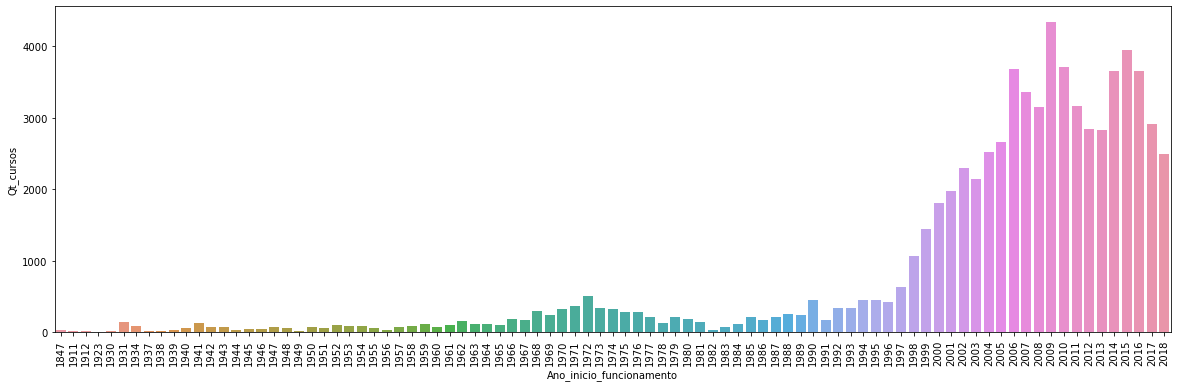

In [71]:
plt.figure(figsize = (20, 6))
s = sn.barplot(data = df_cursos_novos_ano, x = 'Ano_inicio_funcionamento', y = 'Qt_cursos')
plt.xticks(rotation = 90)
plt.show()



# A primeira informação que julgo relevante ser retirada dos dados para iniciarmos essa análise é verificar quantas instituições de ensino superior existiam no pais em 2018 e quantos alunos estavam matriculados nelas.


- **INFORMAÇÃO TÉCNICA:**

Utilizaremos nesse momento a tabela DM_IES do Bando de Dados. Para fazer consultas nessa tabela utilizarei funções do pandas que me permitem utilizar querys SQL para consultar o banco. Essas consultas são retornadas como objetos do tipo DataFrames do pandas, o que me permite utilizar todas as funções de tratamento que as bibliotecas numpy e pandas me fornecem.

Nesse primeiro momento farei sucessivas consultas ao banco, para fins de aprendizado, embora fosse possível fazer apenas uma primeira consulta e criar um DataFrame completo e parcialmente tratado.

In [72]:
#Utilizei a query abaixo, na qual consultei a tabela DM_IES, especificamente as colunas CO_IES e NO_IES. Para do princípio que
#....a coluna CO_IES vão me fornecer um código único, exclusivo de cada IES, o qual figurará como minha Primary Key, no entando, por não
#....por não conhecer os dados ainda optei por buscar na consulta SQL apenas os valores distintos nessa coluna. Assim eu sei que
#....o DataFrame que me será retornado não terá valores duplicados nessa coluna.

query = """
SELECT DISTINCT(CO_IES), NO_IES
from DM_IES

"""

df_ies = pd.read_sql_query(query, db)
df_ies

,CO_IES,NO_IES
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO
1,2,UNIVERSIDADE DE BRASÍLIA
2,3,UNIVERSIDADE FEDERAL DE SERGIPE
3,4,UNIVERSIDADE FEDERAL DO AMAZONAS
4,6,UNIVERSIDADE FEDERAL DE OURO PRETO
...,...,...
2532,23410,UNIVERSIDADE ESTADUAL DA REGIÃO TOCANTINA DO M...
2533,284,FACULDADE DE MEDICINA DE ITAJUBÁ
2534,633,INSTITUTO MILITAR DE ENGENHARIA
2535,3311,Faculdade de Educação Avançada do Noroeste Cap...


In [73]:
#Optei por já armazenar o valor total de IES em uma variável, assim caso, posteriormente, precise desse valor meu código será 
#....mais simples

total_ies = df_ies['NO_IES'].count()
total_ies

2537

# Encontramos que o total de IES no Brasil em 2018 eram de 2.537. Dessas como será a divisão entre instituições privadas e públicas?

- **INFORMAÇÃO TÉCNICA:**


Para sabermos quais dessas Universidades são Públicas ou Privadas temos a coluna TP_CATEGORIA_ADMINISTRATIVA, a qual classifica numericamente os tipos de instituições, no entanto essa classificação se da em 7 categorias diferente, após fazer uma análise ao dicionário de dados verificamos que apenas as 1, 2 e 3 são categorias que se enquadram como Públicas.

In [74]:
#Abaixo para categorizar se as IES são públicas ou privados, utilizei os valores da coluna 'TP_CATEGORIA_ADMINISTRATIVA' 
#....onde criei uma condição para separar tudo em 'Público' ou "Privado", por fim que fosse retornado apenas a coluna 'NO_IES' 
#....a coluna nova 'PUB_PRIV' criada durante a consulta já será retornada.

query = """
SELECT DISTINCT(CO_IES), NO_IES, 
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' OR TP_CATEGORIA_ADMINISTRATIVA = '7' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV
FROM DM_IES

"""
ies_pub_priv = pd.read_sql_query(query, db)
ies_pub_priv

,CO_IES,NO_IES,PUB_PRIV
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,Pública
1,2,UNIVERSIDADE DE BRASÍLIA,Pública
2,3,UNIVERSIDADE FEDERAL DE SERGIPE,Pública
3,4,UNIVERSIDADE FEDERAL DO AMAZONAS,Pública
4,6,UNIVERSIDADE FEDERAL DE OURO PRETO,Pública
...,...,...,...
2532,23410,UNIVERSIDADE ESTADUAL DA REGIÃO TOCANTINA DO M...,Pública
2533,284,FACULDADE DE MEDICINA DE ITAJUBÁ,Privada
2534,633,INSTITUTO MILITAR DE ENGENHARIA,Pública
2535,3311,Faculdade de Educação Avançada do Noroeste Cap...,Privada


In [75]:
ies_pub_priv_soma = ies_pub_priv['PUB_PRIV'].value_counts()

In [76]:
print('-='*62)
print(f'Do total de {total_ies} IES que tinhamos no país em 2018, {ies_pub_priv_soma[0]} eram\
 Instituições Públicas e {ies_pub_priv_soma[1]} tratavam-se de Instituições Privadas')
print('-='*62)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Do total de 2537 IES que tinhamos no país em 2018, 2238 eram Instituições Públicas e 299 tratavam-se de Instituições Privadas
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [77]:
ies_pub_priv_soma

Privada    2238
Pública     299
Name: PUB_PRIV, dtype: int64

# Conforme pode ser visto nos dois gráficos abaixo, dessas *`2.537`* Instituições de Ensino Superior existentes no pais em 2018, 2.238 eram instituições Privadas e *`299`* eram Públicas.

# Isso significa que apenas `12%` das Instituições de Ensino Superior do país eram públicas, o que aparentemente mostra uma ocupação de grande parcela do mercado pelas Instituições de Educação Superior Privada ganhou no país.


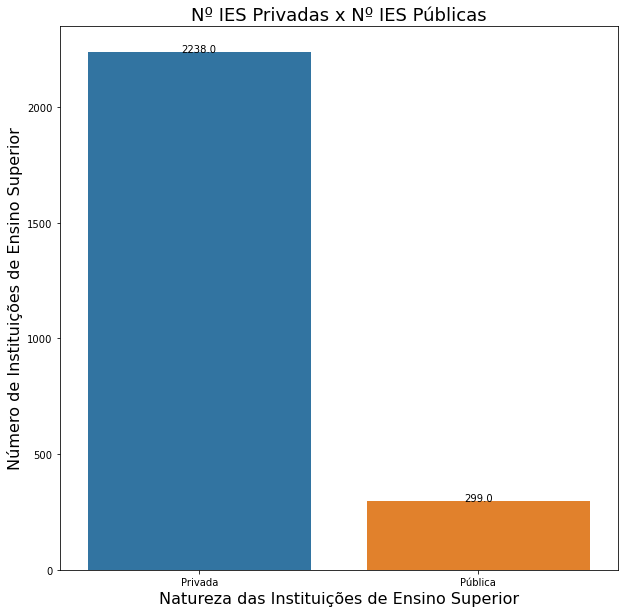

In [78]:
#Definindo o tamanho da figura
plt.figure(figsize=(10, 10))

#Plotando o gráfico com o uso do método barplot da lib seaborn
s = sn.barplot(x= ies_pub_priv_soma.index, y= ies_pub_priv_soma.values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("Número de Instituições de Ensino Superior", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Nº IES Privadas x Nº IES Públicas', fontdict={'fontsize': 18})


#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# 88% das IES do país em 2018 eram privadas.

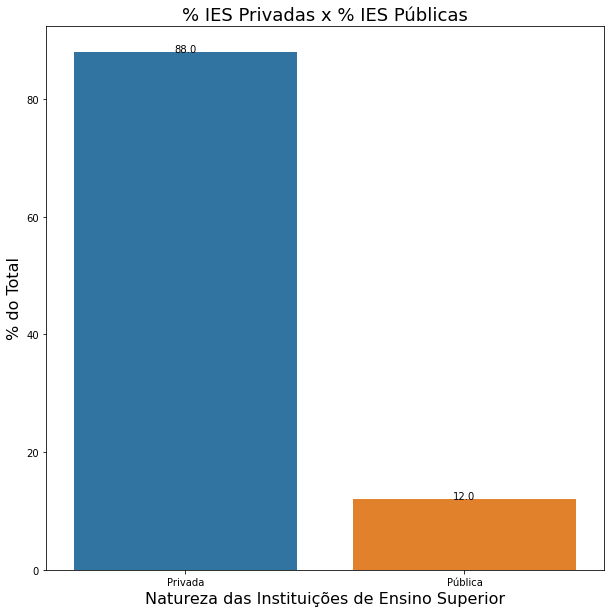

In [79]:
plt.figure(figsize=(10, 10))

#Plotando o gráfico com o uso do método barplot da lib seaborn
s = sn.barplot(x= ies_pub_priv_soma.index, y= np.around((ies_pub_priv_soma.values/ies_pub_priv_soma.values.sum()),2)*100)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("% do Total", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('% IES Privadas x % IES Públicas', fontdict={'fontsize': 18})

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')


# Sabendo que a quantidade de IES Privadas é maior do que as Públicas, importante descobrir a quantidade de estudantes matriculados no país e onde eles estão matriculados, só assim vou saber a real fatia do mercado que as IES Privadas possuem.

In [80]:
#Abaixo realizei uma consulta a tabela DM_CURSO do banco de dados, para dela extrair diversas informações que me serão importantes.
#....Para evitar ter que fazer tratamentos posteriormente já optei por, no momento da consulta, modificar alguma informações de
#....fórmulário que eram apenas numéricas, pelos textos explicativos a eles referentes que encontrei no dicionário de dados.

query = """
SELECT DISTINCT(CO_CURSO), CO_IES, CO_LOCAL_OFERTA, CO_UF, NO_CURSO,
QT_MATRICULA_TOTAL, QT_CONCLUINTE_TOTAL, QT_INGRESSO_TOTAL,
QT_INGRESSO_VAGA_NOVA, QT_VAGA_TOTAL, QT_INSCRITO_TOTAL, 
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' OR TP_CATEGORIA_ADMINISTRATIVA = '7' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
END AS Tipo_Instituição,
CASE
    WHEN TP_MODALIDADE_ENSINO = '1' THEN 'Presencial'
    WHEN TP_MODALIDADE_ENSINO = '2' THEN 'Curso a distância (EAD)'
END as 'Modalidade de Ensino',
CASE
    WHEN TP_NIVEL_ACADEMICO = '1' THEN 'Graduação'
    WHEN TP_NIVEL_ACADEMICO = '2' THEN 'Seqüencial de Formação Específica'
END as 'Nível Acadêmico'

FROM DM_CURSO

"""


df_cursos = pd.read_sql_query(query, db)
df_cursos

,CO_CURSO,CO_IES,CO_LOCAL_OFERTA,CO_UF,NO_CURSO,QT_MATRICULA_TOTAL,QT_CONCLUINTE_TOTAL,QT_INGRESSO_TOTAL,QT_INGRESSO_VAGA_NOVA,QT_VAGA_TOTAL,QT_INSCRITO_TOTAL,PUB_PRIV,Tipo_Instituição,Modalidade de Ensino,Nível Acadêmico
0,1,1,105340.0,51.0,DIREITO,445,76,99,92,95,3144,Pública,Universidade,Presencial,Graduação
1,2,1,105340.0,51.0,CIÊNCIAS ECONÔMICAS,344,38,120,119,121,945,Pública,Universidade,Presencial,Graduação
2,3,1,105340.0,51.0,ENGENHARIA CIVIL,266,34,53,53,55,637,Pública,Universidade,Presencial,Graduação
3,6,1,105340.0,51.0,PEDAGOGIA,326,49,98,98,100,1461,Pública,Universidade,Presencial,Graduação
4,7,1,105340.0,51.0,SERVIÇO SOCIAL,253,23,81,81,83,1449,Pública,Universidade,Presencial,Graduação
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38251,5001430,23459,1094503.0,35.0,GESTÃO COMERCIAL,34,0,36,35,36,90,Pública,Faculdade,Presencial,Graduação
38252,1458085,23700,1095191.0,35.0,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,38,0,41,40,41,156,Pública,Faculdade,Presencial,Graduação
38253,1458087,23700,1095191.0,35.0,GESTÃO DA PRODUÇÃO INDUSTRIAL,40,0,41,40,41,164,Pública,Faculdade,Presencial,Graduação
38254,1465936,23705,1095437.0,35.0,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,33,0,41,41,41,41,Pública,Faculdade,Presencial,Graduação


In [81]:
#Abaixo fiz a contagem do número de alunos matriculados. No DataFrame df_cursos, cada linha representa um curso e nela existe
#....uma feature com a quantidade de matriculas totais naquele curso, naquela IES específica.


total_alunos_matriculados = df_cursos['QT_MATRICULA_TOTAL'].sum()

In [83]:
total_matriculas_publicas = df_cursos[df_cursos['PUB_PRIV'] == 'Pública']['QT_MATRICULA_TOTAL'].sum()

In [85]:
total_matriculas_privadas = df_cursos[df_cursos['PUB_PRIV'] == 'Privada']['QT_MATRICULA_TOTAL'].sum()

In [87]:
alunos_matriculados = df_cursos.groupby('PUB_PRIV')['QT_MATRICULA_TOTAL'].sum()

In [88]:
alunos_matriculados_graduacao = df_cursos[df_cursos['Nível Acadêmico'] == 'Graduação']['QT_MATRICULA_TOTAL'].sum()

# Verificamos que, em 2018, haviam 2537 Instituições de Ensino Superior (IES) no país, nas quais estavam matriculados 8.451.748 alunos. Desse total 6.373.913 alunos estavam matriculados na rede Privada e 2.077.835 na rede Pública.

# Esses dados me informam que, aproximadamente, 75,42% de todas as matrículas realizadas em IES no país, em 2018, foram realizadas em Instituições Privadas, as demais 24,58% das matriculas estão em Instituições Públicas.

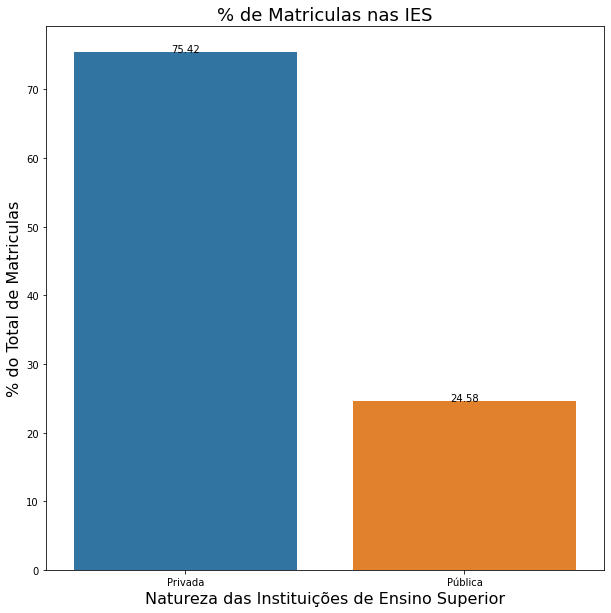

In [89]:
plt.figure(figsize=(10, 10))
s = sn.barplot(x= alunos_matriculados.index, y= np.around((alunos_matriculados.values/alunos_matriculados.values.sum()),4)*100)

plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("% do Total de Matriculas", fontdict={'fontsize':16})

plt.title('% de Matriculas nas IES', fontdict={'fontsize': 18})

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# Portanto, a maior quantidade de alunos matriculados está na rede privada, bem como existe um número muito superior de instituições nessa rede. 

# Continuando na nossa análise, é importante entender como funciona a divisão entre os tipos de instituição, uma vez que existem critérios estabelecidos pelo MEC que dividem os tipos de instituições entre Universidades, Centros Universitários, Faculdades, IF's e Cefet's, esses dois último são exclusivamente Públicos.

In [90]:
query = """
SELECT Tipo_Instituição, COUNT(Tipo_Instituição) as Qnt_tipo
FROM
(SELECT DISTINCT(CO_IES), NO_IES,
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituição
FROM DM_IES) AS tb1

GROUP BY Tipo_Instituição

"""

tipo_instituicao = pd.read_sql_query(query, db)
tipo_instituicao

,Tipo_Instituição,Qnt_tipo
0,Centro Universitário,230
1,Centros Federais (CEFET),2
2,Faculdade,2068
3,Institutos Federais,38
4,Universidade,199


# Existiam, em 2018, 2068 Faculdades no país, além de 199 Universidades, 230 Centros Universitários, 38 Institutos Federais e 2 Cefets

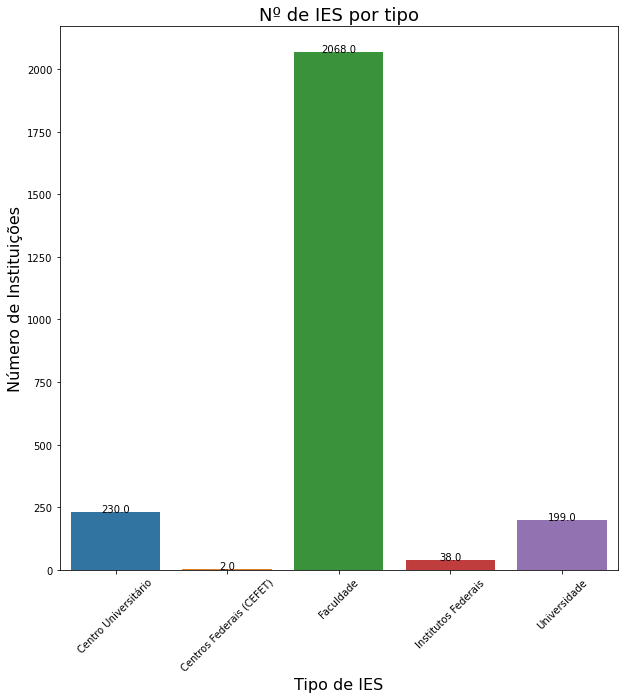

In [91]:
plt.figure(figsize=(10, 10))

s = sn.barplot(data= tipo_instituicao, x= "Tipo_Instituição",
               y= 'Qnt_tipo')

plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("Número de Instituições", fontdict={'fontsize':16})
plt.xticks(rotation = 45)

plt.title('Nº de IES por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

In [92]:
query = """
SELECT PUB_PRIV, Tipo_Instituição, COUNT(Tipo_Instituição) as Qnt_tipo
FROM
(SELECT DISTINCT(CO_IES), NO_IES,
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituição
FROM DM_IES) AS tb1

GROUP BY PUB_PRIV, Tipo_Instituição

"""

tipo_instituicao_pub_priv = pd.read_sql_query(query, db)
tipo_instituicao_pub_priv

,PUB_PRIV,Tipo_Instituição,Qnt_tipo
0,Privada,Centro Universitário,220
1,Privada,Faculdade,1951
2,Privada,Universidade,92
3,Pública,Centro Universitário,10
4,Pública,Centros Federais (CEFET),2
5,Pública,Faculdade,117
6,Pública,Institutos Federais,38
7,Pública,Universidade,107


# Percentualmente, para termos uma melhor comparação, as Faculdades, em 2018, eram 81,5% de todas as IES do país.

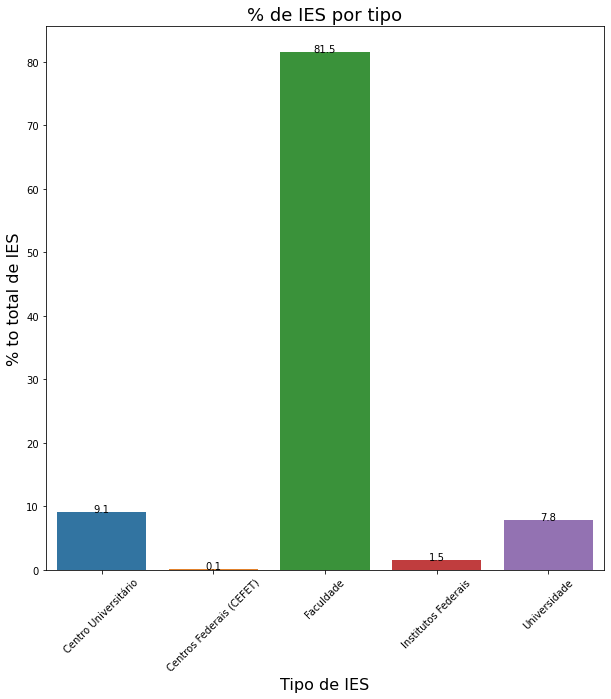

In [93]:
plt.figure(figsize=(10, 10))

s = sn.barplot(data= tipo_instituicao, x= "Tipo_Instituição",
               y= (round(tipo_instituicao["Qnt_tipo"]/tipo_instituicao["Qnt_tipo"].sum(),
               3)*100))

plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("% to total de IES", fontdict={'fontsize':16})
plt.xticks(rotation = 45)

plt.title('% de IES por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Isso se explica por ser muito menos complexo e oneroso se abrir uma Faculdade do que uma Universidades, como podemos ver no quadro comparativos abaixo que retrata as diferenças de obrigações legais entre elas:

Característica | Faculdade | Universidade
---|---|---
Portfólio de cursos | Focada em uma área determinada de conhecimento. | Possui cursos diversos, de diferentes áreas de conhecimento.
Quantidade de cursos | Por oferecer formações específicas, a quantidade de cursos é reduzida. | Por oferecer formações específicas, a quantidade de cursos é reduzida.
Por oferecer formações específicas, a quantidade de cursos é reduzida. | Deve possuir autorização do MEC. | Tem autonomia para criar cursos sem autorização prévia do MEC.
Atividade | Voltada ao ensino, mas pode ter atividades de extensão ou pesquisa. | Além do ensino, promove necessariamente atividades de extensão e pesquisa.
Pesquisa | Não tem obrigação de desenvolver pesquisas. | Deve ter produção intelectual cultural e científica.
Corpo docente | Pelo menos um terço dos professores deve ter título de especialista. Não há necessidade de dedicação integral. | Pelo menos um terço dos professores deve ter título de mestre ou doutor. Um terço do corpo docente também deve se dedicar integralmente.
Pós-graduação | Não tem obrigação de oferecer cursos de pós-graduação. | Deve ter, no mínimo, quatro programas de pós-graduação stricto sensu, sendo ao menos um deles de doutorado.
Comunidade | Não tem obrigação de se relacionar com a comunidade. | Deve criar aproximação com a comunidade e atendê-la.








# Mas  será que ao separar, para análise, as IES em Públicas e Privadas as proporções entre os tipos de Instituições e mantém?

In [94]:
tipo_privadas = tipo_instituicao_pub_priv[tipo_instituicao_pub_priv['PUB_PRIV'] == 'Privada']

In [95]:
tipo_publicas = tipo_instituicao_pub_priv[tipo_instituicao_pub_priv['PUB_PRIV'] == 'Pública']

# Quando analisamos apenas o universo de IES Privadas, vemos que 86% delas são Faculdades, 10% Centros Universitários e apenas 4% Universidades. Cefet's e IF's são instituições exclusivamente públicas pela sua própria natureza, logo, corretamente não aparecem aqui.

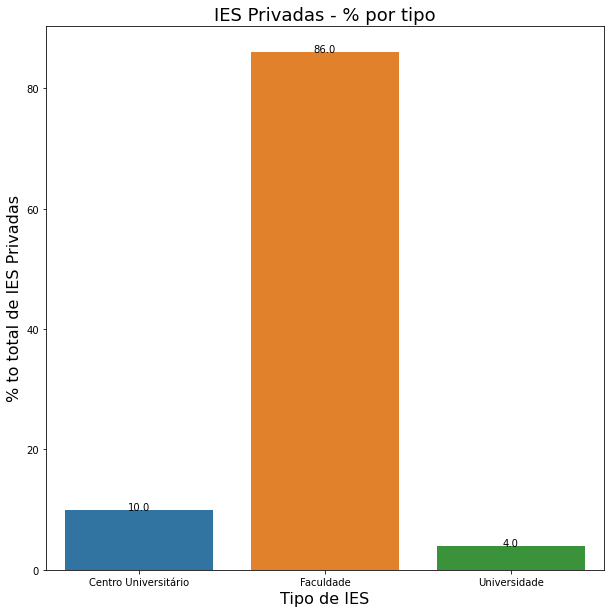

In [96]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= tipo_privadas['Tipo_Instituição'],
               y= round(tipo_privadas['Qnt_tipo']/tipo_privadas['Qnt_tipo'].sum(),2)*100)

plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("% to total de IES Privadas", fontdict={'fontsize':16})

plt.title('IES Privadas - % por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Quando analisamos apenas o universo de IES Públicas, vemos que há um equilíbrio muito maior entre Faculdades (43%) e Universidades (39%).

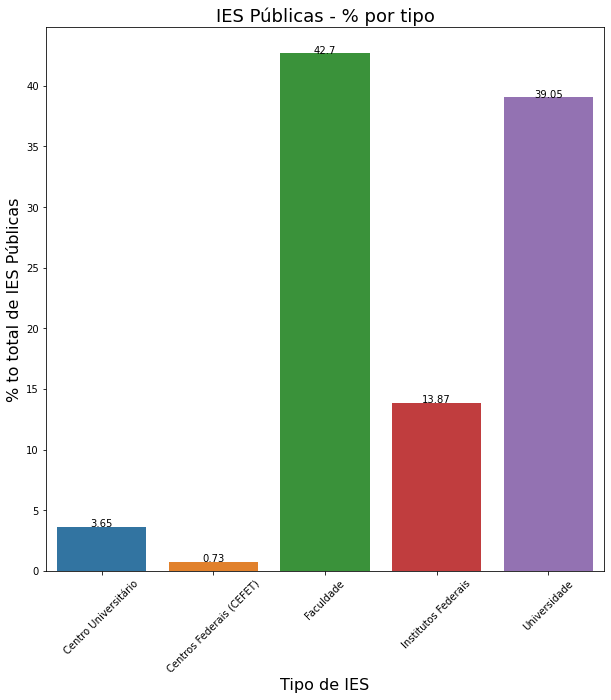

In [625]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= tipo_publicas['Tipo_Instituição'],
               y= round((tipo_publicas['Qnt_tipo']/tipo_publicas['Qnt_tipo'].sum())*100,2))

plt.xticks(rotation = 45)
plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("% to total de IES Públicas", fontdict={'fontsize':16})

plt.title('IES Públicas - % por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Observamos também que 75,42% das matriculas realizadas no pais, em 2018, estão na rede privada e 24,58% na rede pública, conforme podemos ver abaixo:

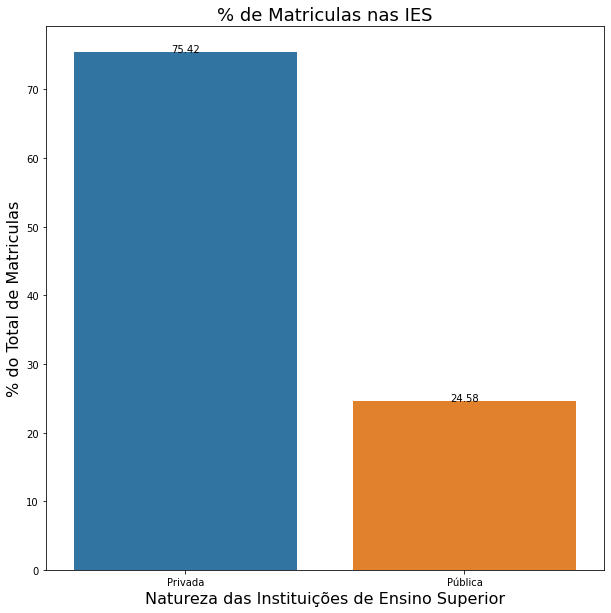

In [98]:
plt.figure(figsize=(10, 10))
s = sn.barplot(x= alunos_matriculados.index, y= np.around((alunos_matriculados.values/alunos_matriculados.values.sum()),4)*100)

plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("% do Total de Matriculas", fontdict={'fontsize':16})

plt.title('% de Matriculas nas IES', fontdict={'fontsize': 18})

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Mas qual será a relevância de cada tipo de instituição nesse volume de matrículas? Pois eu quero saber onde os alunos estão, ou seja, qual o tipo de instituição mais procurada.

- **INFORMAÇÕES TÉCNICAS:**

Aqui fiz uma opção que precisa ser salientada. No que diz respeito as cursos existem 2 níveis acadêmicos, Graduação e Outros cursos sequenciais. Considerei apenas os dados relativos a **GRADUAÇÕES**. 

In [142]:
alunos_tipo_ies = (df_cursos[df_cursos['Nível Acadêmico'] == 'Graduação'].groupby('Tipo_Instituição')['QT_MATRICULA_TOTAL'].sum()).sort_values()
alunos_tipo_ies

Tipo_Instituição
Centros Federais (CEFET)      13799
Institutos Federais          183707
Faculdade                   1879228
Centro Universitário        1906327
Universidade                4467694
Name: QT_MATRICULA_TOTAL, dtype: int64

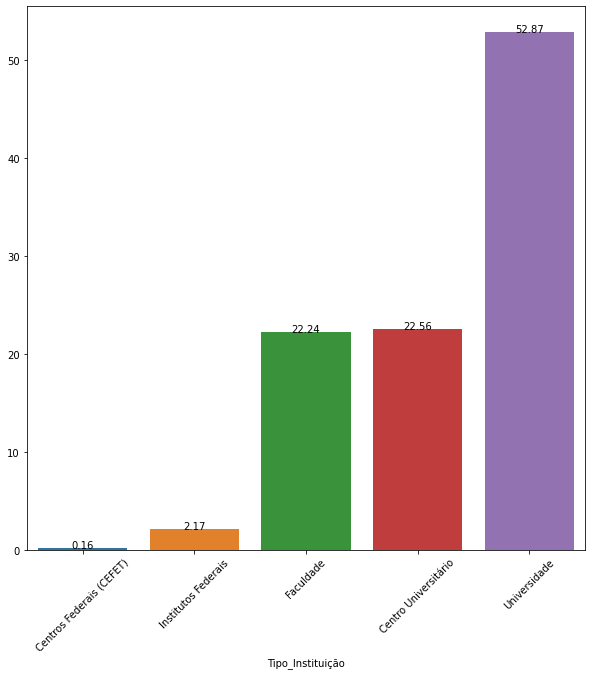

In [143]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= alunos_tipo_ies.index, y= np.around(alunos_tipo_ies.values/alunos_tipo_ies.values.sum(),4)*100)
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# E aqui percebemos que embora as Universidades sejam 7,9% das IES do país, nelas se concentraram 52,87% de todas as matrículas, em contrapartida, nas Faculdades que são 81,5% das IES do país, temos apenas 22% das matrículas, aproximadamente.

# Ampliando essa análise para extratificar as matriculas por tipo de instituição entre as redes públicas e privadas, pois é uma informação importante para ententer a relevância em relação ao total de matrículas nas IES no país, encontramos o seguinte:

In [144]:
matriculas_publicas = df_cursos[(df_cursos['Nível Acadêmico'] == 'Graduação') & (df_cursos['PUB_PRIV'] == 'Pública')].groupby('Tipo_Instituição')['QT_MATRICULA_TOTAL'].sum().sort_values()
matriculas_publicas

Tipo_Instituição
Centros Federais (CEFET)      13799
Centro Universitário          23851
Faculdade                    121124
Institutos Federais          183707
Universidade                1735000
Name: QT_MATRICULA_TOTAL, dtype: int64

# De todas as matriculas em IES no país, em 2018, 20,53% desses alunos estão em Universidades públicas.

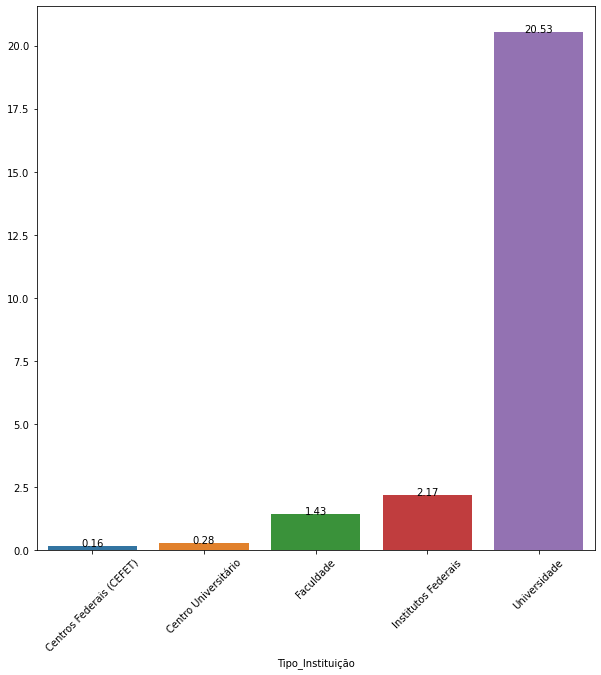

In [148]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= matriculas_publicas.index, y= np.around((matriculas_publicas.values/alunos_tipo_ies.values.sum())*100,2))
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

In [66]:
matriculas_privadas = df_cursos[(df_cursos['Nível Acadêmico'] == 'Graduação') & (df_cursos['PUB_PRIV'] == 'Privada')].groupby('Tipo_Instituição')['QT_MATRICULA_TOTAL'].sum().sort_values()
matriculas_privadas

Tipo_Instituição
Faculdade               1758104
Centro Universitário    1882476
Universidade            2732694
Name: QT_MATRICULA_TOTAL, dtype: int64

# De todas as matriculas em IES no país, em 2018, 32,34% desses alunos estão em universidades privadas, 22,28% em centros universitários privados e, 20,8% em faculdades privadas.

# Com essa informação acima eu consigo entender claramente o tamanho do mercado de IES privadas no país como um todo, bem como vejo que embora as Universidades Privadas, tenham mais matrículas, o que já era imaginado, pois elas abrigam um número muito maior de curso,as Faculdades e Centros universitários também vem tendo ampla demanda.


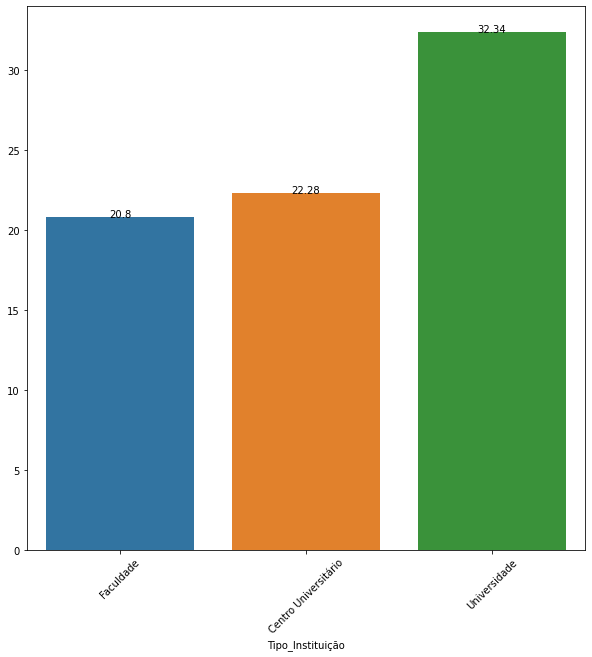

In [70]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= matriculas_privadas.index, y= np.around(matriculas_privadas.values/alunos_tipo_ies.values.sum(),4)*100)
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Essa realidade pode ou não se confirmar em todos os estados da federação, isto é o que analisaremos abaixo, observando a distribuição estado a estado:

In [75]:
query = """

SELECT temp_tab2.SIG_UF, temp_tab2.PUB_PRIV, COUNT(temp_tab2.PUB_PRIV) as Qnt_IES
FROM

(SELECT temp_tab.NO_IES, temp_tab.NO_UF, temp_tab.SIG_UF,
CASE
    WHEN temp_tab.TP_CATEGORIA_ADMINISTRATIVA = '1' OR temp_tab.TP_CATEGORIA_ADMINISTRATIVA = '2' OR temp_tab.TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END as PUB_PRIV
FROM 

(SELECT DISTINCT tb1.CO_UF,
        tb1.NO_IES,
        tb1.TP_CATEGORIA_ADMINISTRATIVA,
        tb1.TP_ORGANIZACAO_ACADEMICA,
        tb2.NO_UF,
        tb2.SIG_UF
FROM 
    DM_IES AS tb1
JOIN
    estados AS tb2
    
    ON tb1.CO_UF = tb2.CO_UF) as temp_tab
    ) as temp_tab2
    
GROUP BY temp_tab2.SIG_UF, temp_tab2.PUB_PRIV

"""

df_PubPriv = pd.read_sql_query(query, db) 
df_PubPriv

,SIG_UF,PUB_PRIV,Qnt_IES
0,AC,Privada,9
1,AC,Pública,2
2,AL,Privada,25
3,AL,Pública,4
4,AM,Privada,20
5,AM,Pública,3
6,AP,Privada,12
7,AP,Pública,3
8,BA,Privada,135
9,BA,Pública,10


# Agora temos uma DataFrame com o número total de universidades públicas e privadas para cada estado do Brasil para podermos analisar.

# Abaixo conseguimos analisar detalhadamente a presença de instituições privadas e públicas em cada estado da federação. É possível perceber há alguns estados onde o número de IES privadas se destaca, por ser muito supeior aos demais estados, Obviamente há que se levar em conta a demanda existente em cada estado, o que podemos começar a mensurar analisando a população local, no entanto só pelo gráfico abaixo podemos tirar algumas conclusões.

# Temos estados como MG em que o número de IES privadas é 14 vezes maior do que o de públicas, bem como em outros, como RR esse número é de apenas 1.5 vezes maior.

# Temos IES públicas em todos os estados do país, bem como não há em nenhum deles presença de IES públicas maior do que o de privadas, o que é algo que já imaginávamos, mas aqui se confirma.

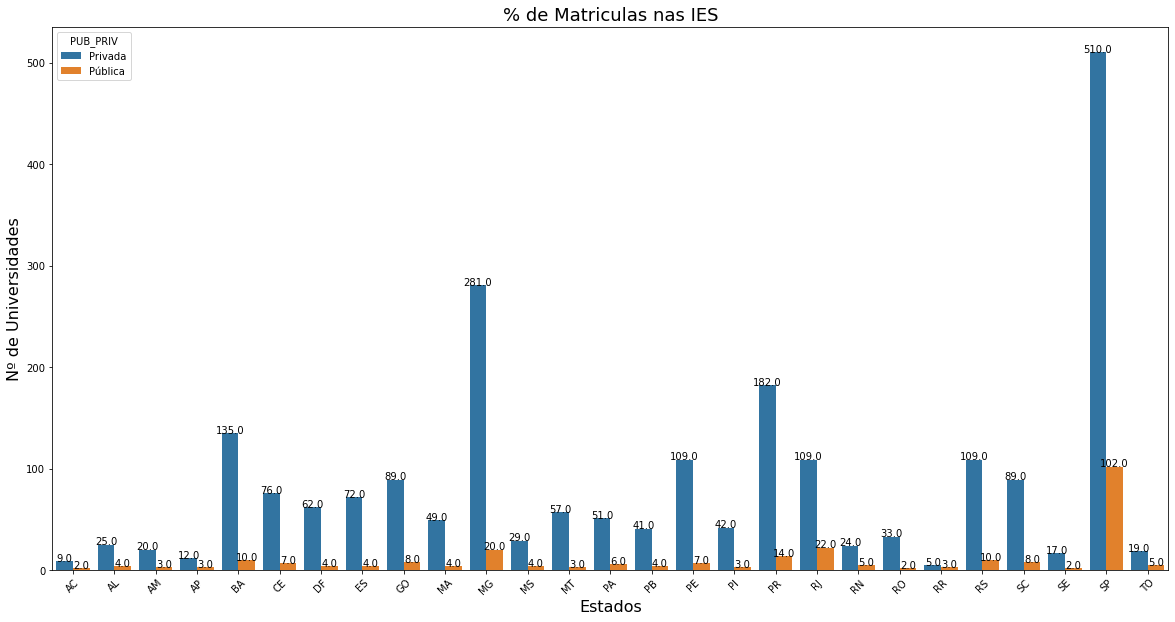

In [142]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= df_PubPriv.SIG_UF, y= df_PubPriv.Qnt_IES, hue= df_PubPriv.PUB_PRIV)
plt.xlabel("Estados", fontdict={'fontsize':16})
plt.ylabel("Nº de Universidades", fontdict={'fontsize':16})

plt.title('% de Matriculas nas IES', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Pelo gráfico acima conseguimos ver claramente como se dá a distribuição das instituições de ensino superior no país. Quando analisamos a quantidade de IES públicas vemos uma uniformidade muito maior na distribuição, pois é dever do Estado prover essa educação, o unico ponto fora da curva é SP estado que tem aproximente 21% da população total do país), no entanto foi contemplado com quase 38% da IES públicas.

**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# Já entendemos o comportamento das matriculas no que diz respeitos as Instituições de Ensino, mas como vem sendo a evolução da oferta e da demanda dos cursos de educação superior no modelo EAD?


In [118]:
# Verificando que não existem rows com dados totalmente identicos, logo, não existem cursos de uma mesma instituição de ensino
#....duplicados nessa lista

df_cursos.duplicated().sum()

0

In [119]:
#Precisei modificar os tipos das colunas CO_CURSO e CO_IES, pois eu quero fazer uma combinação entre elas e não uma soma, como
#....ambas são do tipo 'int' caso ou tive um CO_CURSO = 1 e um CO_IES = 1, da forma como estão agora o somatório entre elas será
#....2, mas eu quero uma combinação entre os valores que me dê 11, para isso eu preciso inicialmente mudar os tipos para 'object'

df_cursos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38256 entries, 0 to 38255
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CO_CURSO               38256 non-null  int64  
 1   CO_IES                 38256 non-null  int64  
 2   CO_LOCAL_OFERTA        35076 non-null  float64
 3   CO_UF                  35076 non-null  float64
 4   NO_CURSO               38256 non-null  object 
 5   QT_MATRICULA_TOTAL     38256 non-null  int64  
 6   QT_CONCLUINTE_TOTAL    38256 non-null  int64  
 7   QT_INGRESSO_TOTAL      38256 non-null  int64  
 8   QT_INGRESSO_VAGA_NOVA  38256 non-null  int64  
 9   QT_VAGA_TOTAL          38256 non-null  int64  
 10  QT_INSCRITO_TOTAL      38256 non-null  int64  
 11  PUB_PRIV               38256 non-null  object 
 12  Tipo_Instituição       38256 non-null  object 
 13  Modalidade de Ensino   38256 non-null  object 
 14  Nível Acadêmico        38256 non-null  object 
dtypes:

In [121]:
df_cursos = df_cursos.astype({'CO_CURSO':'str',
                                     'CO_IES': 'str'})

In [123]:
df_cursos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38256 entries, 0 to 38255
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CO_CURSO               38256 non-null  object 
 1   CO_IES                 38256 non-null  object 
 2   CO_LOCAL_OFERTA        35076 non-null  float64
 3   CO_UF                  35076 non-null  float64
 4   NO_CURSO               38256 non-null  object 
 5   QT_MATRICULA_TOTAL     38256 non-null  int64  
 6   QT_CONCLUINTE_TOTAL    38256 non-null  int64  
 7   QT_INGRESSO_TOTAL      38256 non-null  int64  
 8   QT_INGRESSO_VAGA_NOVA  38256 non-null  int64  
 9   QT_VAGA_TOTAL          38256 non-null  int64  
 10  QT_INSCRITO_TOTAL      38256 non-null  int64  
 11  PUB_PRIV               38256 non-null  object 
 12  Tipo_Instituição       38256 non-null  object 
 13  Modalidade de Ensino   38256 non-null  object 
 14  Nível Acadêmico        38256 non-null  object 
dtypes:

In [124]:
df_cursos['ID curso/ies'] = df_cursos['CO_CURSO'].str.cat(df_cursos['CO_IES'],sep="")

In [126]:
#Conferi que não há nenhuma duplicação, logo, posso continuar com a análise.

df_cursos['ID curso/ies'].duplicated().sum()

0

In [127]:
df_cursos_graduacao = df_cursos[df_cursos['Nível Acadêmico'] == 'Graduação']

In [128]:
presencial_EAD = df_cursos_graduacao.groupby(['Modalidade de Ensino'])['NO_CURSO'].count()

# Existiam 35034 Cursos presenciais no país, em 2018, e 3177 cursos EAD.

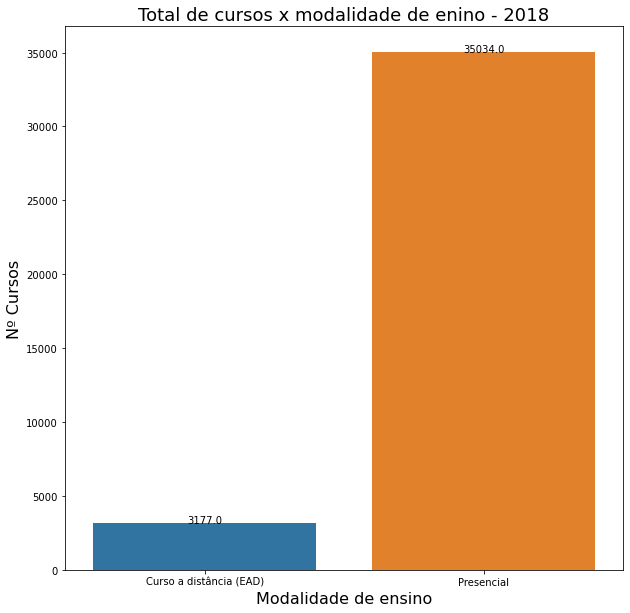

In [627]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= presencial_EAD.index, y= presencial_EAD.values)

plt.xlabel("Modalidade de ensino", fontdict={'fontsize':16})
plt.ylabel("Nº Cursos", fontdict={'fontsize':16})

plt.title('Total de cursos x modalidade de enino - 2018', fontdict={'fontsize': 18})

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Percentualmente falando, em 2018, 91,6% dos cursos de educação superior no país eram presenciais.

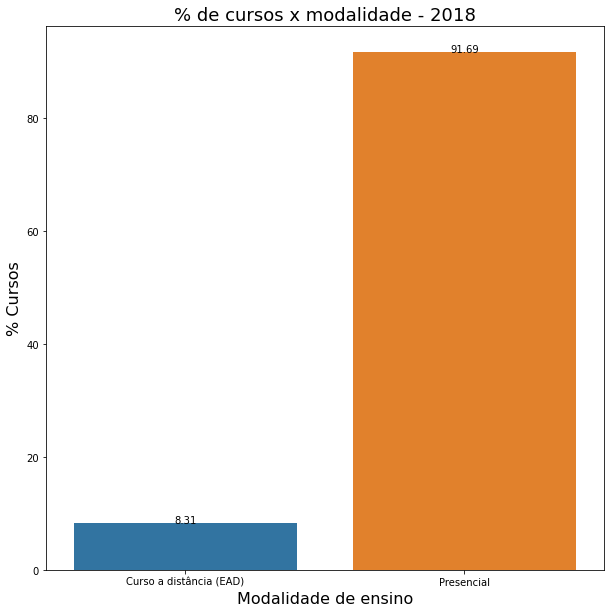

In [626]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= presencial_EAD.index, y= np.around((presencial_EAD.values/presencial_EAD.values.sum())*100,2))

plt.xlabel("Modalidade de ensino", fontdict={'fontsize':16})
plt.ylabel("% Cursos", fontdict={'fontsize':16})

plt.title('% de cursos x modalidade - 2018', fontdict={'fontsize': 18})

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Mas será que essa enorme diferença nos mostra a tendência, uma vez que a cada dia vemos mais cursos EAD pelo país?

In [134]:
qnt_matriculas = df_cursos_graduacao.groupby(['Modalidade de Ensino'])['QT_MATRICULA_TOTAL'].sum()
qnt_matriculas

Modalidade de Ensino
Curso a distância (EAD)    2056511
Presencial                 6394244
Name: QT_MATRICULA_TOTAL, dtype: int64

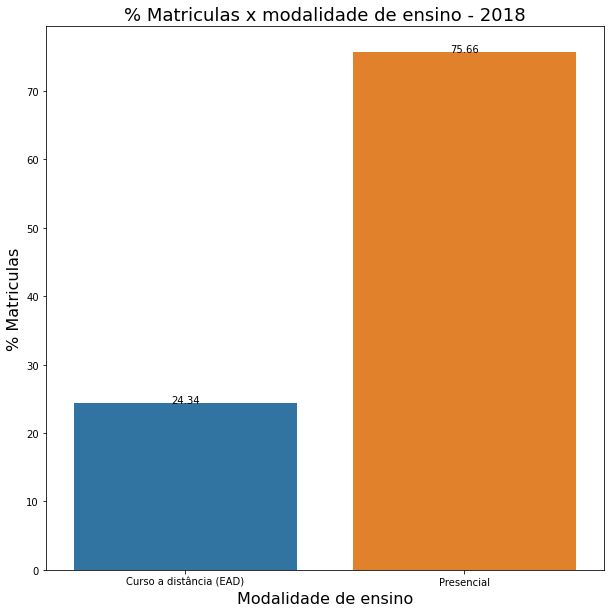

In [630]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= qnt_matriculas.index, y= np.around((qnt_matriculas.values/qnt_matriculas.values.sum())*100,2))

plt.xlabel("Modalidade de ensino", fontdict={'fontsize':16})
plt.ylabel("% Matriculas", fontdict={'fontsize':16})

plt.title('% Matriculas x modalidade de ensino - 2018', fontdict={'fontsize': 18})
               


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# O que podemos observar pelo gráfico acima é que, embora já saibamos que os cursos EAD, em 2018, fossem apenas 8,3% do total de Cursos de Ensino Superior ofertados no país, o valume de matrículas nesse ano para esses cursos já correspondiam a 24,3% do número total de matrículas do país.

In [678]:
evolucao_ead = pd.read_csv('D:/caiof/MATERIAL DE ESTUDO OUTROS/DATA SCIENCE/CURSO - DATA SCIENCE - DIGITAL HOUSE/Modulo 1/Aula27_20220427_Desafio_1/IES no pais.csv', sep=';', encoding='latin1')

In [679]:
evolucao_ead = evolucao_ead[evolucao_ead['Ano']>2008]

In [680]:
evolucao_ead

,Ano,IESPublicas,IESPrivadas,IESTotal,CursosPublicos,CursosPrivados,CursosTotal,CursosPresenciais,CursosEAD,CursosGraduaçãoTotal,MatriculasPublicas,MatriculasPrivadas,MatriculasGraduaçãoTotal,MatriculasPresencial,MatriculasEAD,IngressosIESPublica,IngressosIESPrivada,IngressoIESPresencial,IngressoIESEAD,IngressosIES,ConcludentesIESPublica,ConcludentesIESPrivada,ConcludentesIESPresencial,ConcludentesIESEAD,ConcludentesIES
8,2009,245.0,2069.0,2314.0,8628.0,20043.0,28671.0,27827.0,844.0,28671.0,1523864,4430157,5954021,5115896.0,838125.0,422320.0,1642762.0,1732613.0,332469.0,2065082.0,206877.0,752320.0,826928.0,132269.0,959197.0
9,2010,279.0,2099.0,2378.0,9245.0,20262.0,29507.0,28577.0,930.0,29507.0,1643298,4736001,6379299,5449120.0,930179.0,475884.0,1706345.0,1801901.0,380328.0,2182229.0,190597.0,783242.0,829286.0,144553.0,973839.0
10,2011,284.0,2081.0,2365.0,9833.0,20587.0,30420.0,29376.0,1044.0,30420.0,1773315,4966374,6739689,5746762.0,992927.0,490680.0,1856015.0,1915098.0,431597.0,2346695.0,218365.0,798348.0,865161.0,151552.0,1016713.0
11,2012,304.0,2112.0,2416.0,10905.0,20961.0,31866.0,30718.0,1148.0,31866.0,1897376,5140312,7037688,5923838.0,1113850.0,547897.0,2199192.0,2204456.0,542633.0,2747089.0,237546.0,812867.0,176091.0,174322.0,350413.0
12,2013,301.0,2090.0,2391.0,10850.0,21199.0,32049.0,30791.0,1248.0,32039.0,1932527,5373450,7305977,6152405.0,1153572.0,531846.0,2211104.0,2227545.0,515405.0,2742950.0,229278.0,761732.0,829938.0,161072.0,991010.0
13,2014,298.0,2070.0,2368.0,11036.0,21842.0,32878.0,31513.0,1365.0,32878.0,1961002,5867011,7828013,6486171.0,1341842.0,548542.0,2562306.0,2383110.0,727738.0,3110848.0,241765.0,785327.0,837304.0,189788.0,1027092.0
14,2015,295.0,2069.0,2364.0,10769.0,22732.0,33501.0,32028.0,1473.0,33501.0,1952145,6075152,8027297,6633545.0,1393752.0,534361.0,2385861.0,2225663.0,694559.0,2920222.0,239896.0,910171.0,916363.0,233704.0,1150067.0
15,2016,296.0,2111.0,2407.0,10542.0,23824.0,34366.0,32704.0,1662.0,34366.0,1990078,6058623,8048701,6554283.0,1494418.0,529492.0,2456152.0,2142463.0,843181.0,2985644.0,246875.0,922574.0,938732.0,230717.0,1169449.0
16,2017,296.0,2152.0,2448.0,10425.0,24955.0,35380.0,33272.0,2108.0,35380.0,2045356,6241307,8286663,6529681.0,1756982.0,589586.0,2636663.0,2152752.0,1073497.0,3226249.0,251793.0,947976.0,947606.0,252163.0,1199769.0
17,2018,299.0,2238.0,2537.0,10526.0,27436.0,37962.0,34785.0,3177.0,37962.0,2077481,6373274,8450755,6394244.0,2056511.0,580936.0,2864999.0,2072614.0,1373321.0,3445935.0,259302.0,1044986.0,990415.0,273873.0,1264288.0


# Podemos ver abaixo que há um claro crescimento no número de cursos EAD que vem sendo criados ano a ano. Se olharmos para o número de cursos nessa modalidade de ensino em 2018 e em 2020 vemos um crescimento de quase 100%, de 3177 para 6167.

# Obviamente temos que considerar que o advento da pandemia teve grande impacto nesse exponencial crescimento em 2020, mas mesmo se desconsiderarmos esse ano, entre 2018 e 2019 o crescimento já havia sido de 42%.

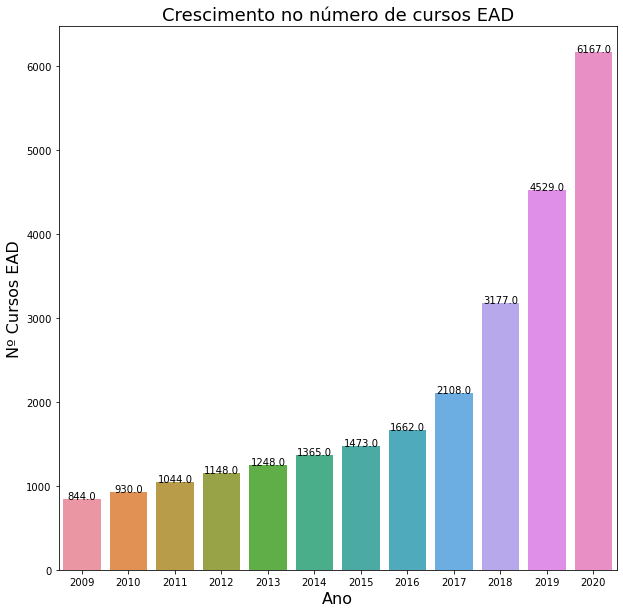

In [681]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= evolucao_ead['Ano'], y= evolucao_ead['CursosEAD'])

plt.xlabel("Ano", fontdict={'fontsize':16})
plt.ylabel("Nº Cursos EAD", fontdict={'fontsize':16})

plt.title('Crescimento no número de cursos EAD', fontdict={'fontsize': 18})
               


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Observamos a mesma curva crescento quando se trata do número de matriculas, ano após ano elas vem crescendo de 2009 até 2020, sem nenhum ano de diminuição, mesmo o país tendo passado por anos de turbulência política e estagnação econômica.

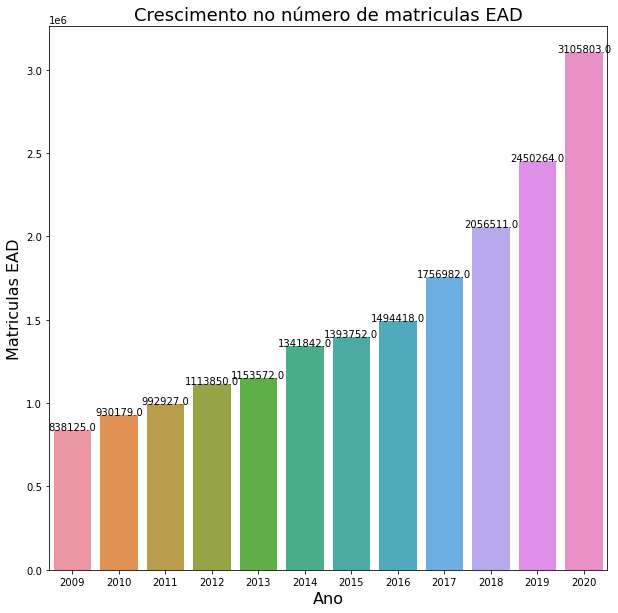

In [682]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= evolucao_ead['Ano'], y= evolucao_ead['MatriculasEAD'])

plt.xlabel("Ano", fontdict={'fontsize':16})
plt.ylabel("Matriculas EAD", fontdict={'fontsize':16})

plt.title('Crescimento no número de matriculas EAD', fontdict={'fontsize': 18})
               


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

In [686]:
evolucao_ead['%MatriculasEAD'] = round((evolucao_ead['MatriculasEAD']/evolucao_ead['MatriculasGraduaçãoTotal'])*100,2)

In [691]:
evolucao_ead['%IngressosEAD'] = round((evolucao_ead['IngressoIESEAD']/evolucao_ead['IngressosIES'])*100,2)

# Os dados são ainda mais representativos quando olhados para o percentual de matriculas EAD em relação ao número total de matriculas em graduação no país.  Após anos de crescimento, em 2020 as matriculas EAD no país já representavam 35,78% do total.

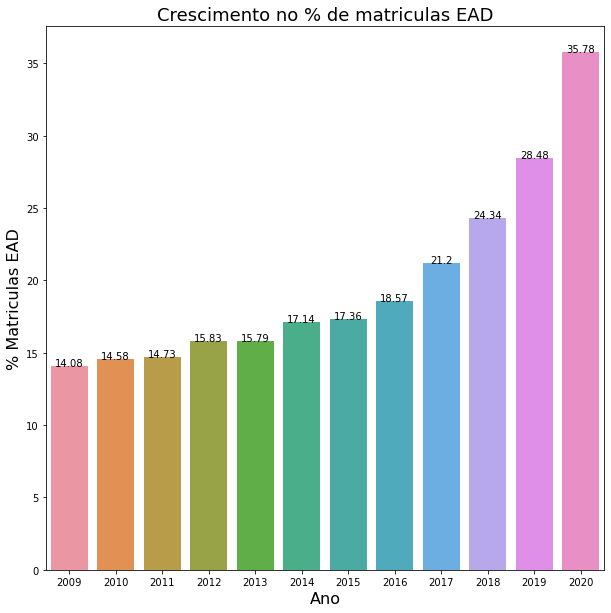

In [687]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= evolucao_ead['Ano'], y= evolucao_ead['%MatriculasEAD'])

plt.xlabel("Ano", fontdict={'fontsize':16})
plt.ylabel("% Matriculas EAD", fontdict={'fontsize':16})

plt.title('Crescimento no % de matriculas EAD', fontdict={'fontsize': 18})
               


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Mas mesmo já sabendo que o número de matriculas EAD vem crescendo, como podemos saber se esse crescimento irá continuar ocorrendo.

# Para isso analisamos o % de ingressos em IES no país, esses dados demonstram a tendência para os anos que virão e em 2020, pela primeira vez na historia o % de novos alunos ingressando na educação superior em cursos EAD foi maior dos que os ingressos em cursos presenciais.

# Podemos afirmar com esses dados a tendência para que os cursos EAD ocupem cada vês mais espaço irá continuar, por há demanda por essa modalidade de ensino, como os novos ingressos demonstram claramente.

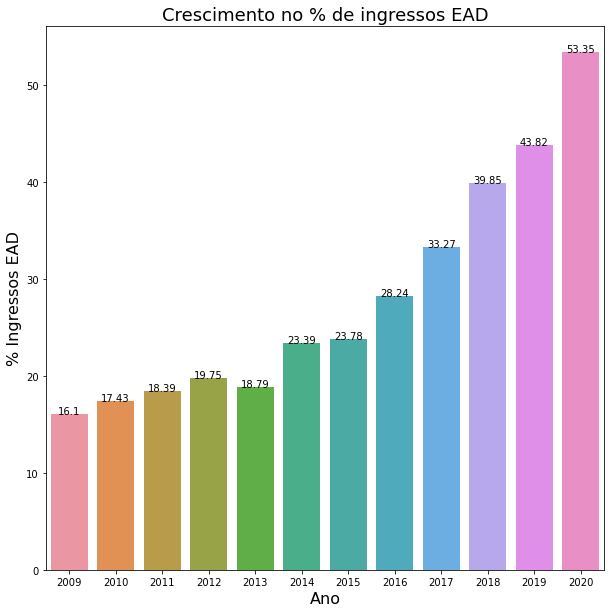

In [692]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= evolucao_ead['Ano'], y= evolucao_ead['%IngressosEAD'])

plt.xlabel("Ano", fontdict={'fontsize':16})
plt.ylabel("% Ingressos EAD", fontdict={'fontsize':16})

plt.title('Crescimento no % de ingressos EAD', fontdict={'fontsize': 18})
               


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# Vamos nos aprofundar um pouco mais na nossa análise dos dados do Censo de 2018. 

# Quais cursos vem tendo maior interesse por parte dos alunos, ou seja, em quais cursos `presenciais` eu tenho mais alunos matriculados?


In [101]:
#Abaixo fiz uma consulta ao banco de dados, na qual utilizei o conceito de subquerys, pois fiz uma primeira consulta a qual
#....em sequência encapsulei. Essa tabela de retorno fiz um join com a tabela de Estados para obter a Sigla e nome dos estados
#....em substituição ao mero código, pois essa informaçãoe ra de difícil compreensão.
#....Por fim nessa query modifiquei diversos valores que anteriormente estavam em códigos pelos textos que cada código representa
#....bem como limitei a consulta à apenas os cursos presenciais. Isso foi feito, pois os cursos a distância não tem valores na
#....coluna CO_UF, o que atrapalhava minha busca. Como retorno tenho uma tabela com todos os cursos presenciais do país e, dentre
#....outras informações o estado onde cada curso se localiza e o número de matrículas.


query = """

SELECT
    tb_temp.CO_CURSO,
    tb_temp.CO_IES,
    ESTADOS.SIG_UF,
    ESTADOS.NO_UF,
    tb_temp.NO_CURSO,
    tb_temp.QT_MATRICULA_TOTAL,
    tb_temp.PUB_PRIV,
    tb_temp.Tipo_Instituicao,
    tb_temp.NU_ANO_CENSO,
    tb_temp.QT_INGRESSO_TOTAL,
    tb_temp.QT_INGRESSO_VAGA_NOVA,
    tb_temp.QT_INSCRITO_TOTAL,
    tb_temp.QT_CONCLUINTE_TOTAL,
    tb_temp.QT_VAGAS_NOVAS_INTEGRAL,
    tb_temp.QT_VAGAS_NOVAS_MATUTINO,
    tb_temp.QT_VAGAS_NOVAS_VESPERTINO,
    tb_temp.QT_VAGAS_NOVAS_NOTURNO,
    tb_temp.QT_VAGAS_NOVAS_EAD,
    tb_temp.QT_INSC_VAGA_NOVA_INTEGRAL,
    tb_temp.QT_INSC_VAGA_NOVA_MATUTINO,
    tb_temp.QT_INSC_VAGA_NOVA_VESPERTINO,
    tb_temp.QT_INSC_VAGA_NOVA_NOTURNO,
    tb_temp.QT_INSC_VAGA_NOVA_EAD

FROM
(SELECT
    DISTINCT CO_CURSO,
    CO_IES,
    CO_UF,
    NO_CURSO,
    QT_MATRICULA_TOTAL,
    NU_ANO_CENSO,
    QT_INGRESSO_TOTAL,
    QT_INGRESSO_VAGA_NOVA,
    QT_INSCRITO_TOTAL,
    QT_CONCLUINTE_TOTAL,
    QT_VAGAS_NOVAS_INTEGRAL,
    QT_VAGAS_NOVAS_MATUTINO,
    QT_VAGAS_NOVAS_VESPERTINO,
    QT_VAGAS_NOVAS_NOTURNO,
    QT_VAGAS_NOVAS_EAD,
    QT_INSC_VAGA_NOVA_INTEGRAL,
    QT_INSC_VAGA_NOVA_MATUTINO,
    QT_INSC_VAGA_NOVA_VESPERTINO,
    QT_INSC_VAGA_NOVA_NOTURNO,
    QT_INSC_VAGA_NOVA_EAD,

CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END as PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituicao,
CASE
    WHEN TP_MODALIDADE_ENSINO = '1' THEN 'Presencial'
    ELSE 'Curso a distância (EAD)'
END as Modalidade_Ensino
FROM DM_CURSO

WHERE Modalidade_Ensino = 'Presencial' AND TP_NIVEL_ACADEMICO = '1') as tb_temp

JOIN
    ESTADOS
    ON ESTADOS.CO_UF = tb_temp.CO_UF


"""
cursos_graduacao_presenciais = pd.read_sql_query(query, db) 

In [102]:
pd.set_option('display.max_columns', 80)

- **INFORMAÇÃO TÉCNICA**
Os DataFrames cursos_graduacao_presenciais e cursos_graduacao_ead serão a base de nossas análises exploratórias daqui para frente

In [103]:
#Abaixo fiz o agrupamento por nome do curso e, para cada um dos agrupamentos, somei os valores da feature que representava a
#....quantidade de matriculas, por fim ordenei esse somatório de forma decrescente para assim ter um Serie com a quantidade de
#....matriculas no pais curso a curso, do que teve mais matrículas para o que teve menos. Guardei essa Serie em uma variável
#....para facilitar a manipulação na célula onde proteio gráfico

total_matriculas_presenciais = cursos_graduacao_presenciais.groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False)

# Abaixo temos os 50 cursos presenciais com maior número de alunos matriculados no Brasil em 2018.

# Cursos tradicionais como Direito, Administração, Engenharia Civil, Enfermagem, Pedagogia, Psicologia, Contábeis, Educação Física, Fisioterapia e Medicina, continuam sendo os 10 cursos com maior numero de alunos, nesta ordem que foram apresentados.

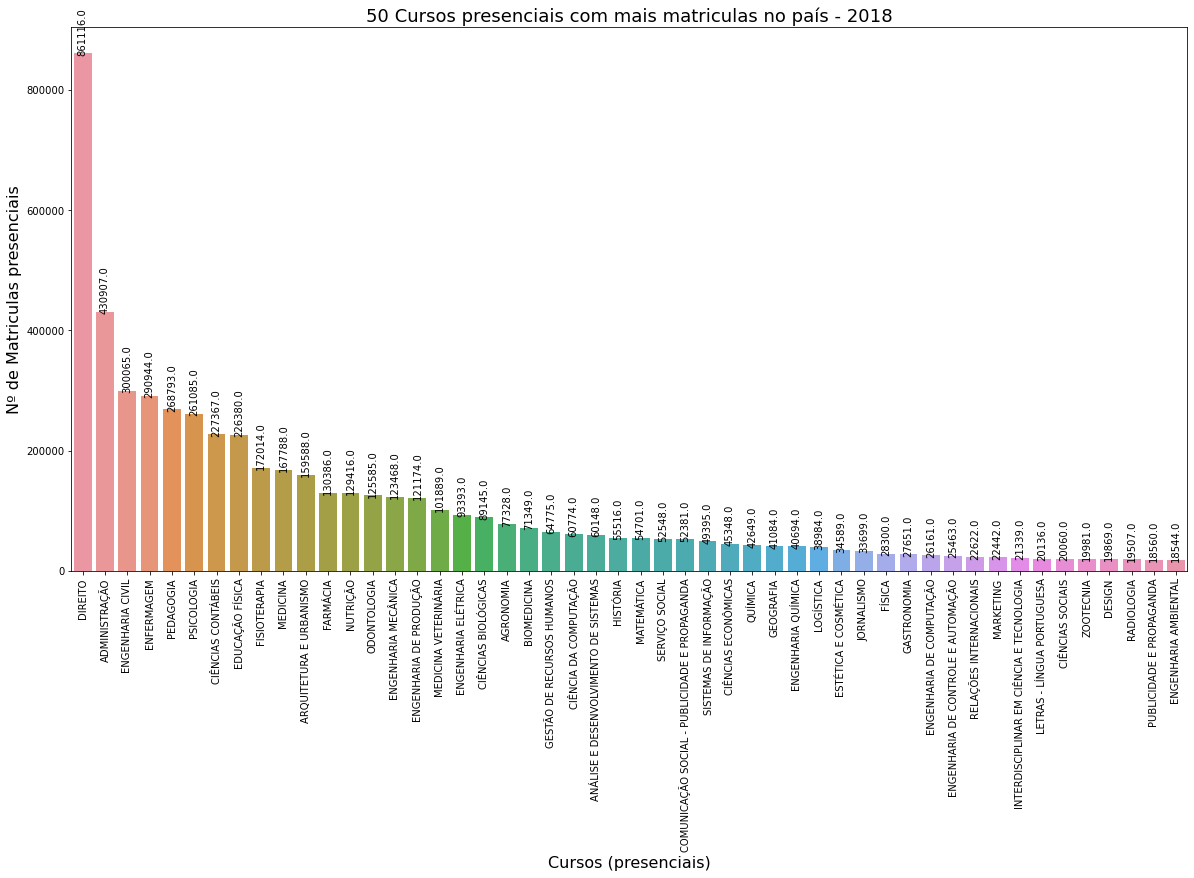

In [268]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= total_matriculas_presenciais.sort_values(ascending=False).head(50).index, y= total_matriculas_presenciais.sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (presenciais)", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas presenciais", fontdict={'fontsize':16})

plt.title('50 Cursos presenciais com mais matriculas no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Abaixo podemos observer essa análise em termos percentuais (%) do total de matriculas presenciais no país.

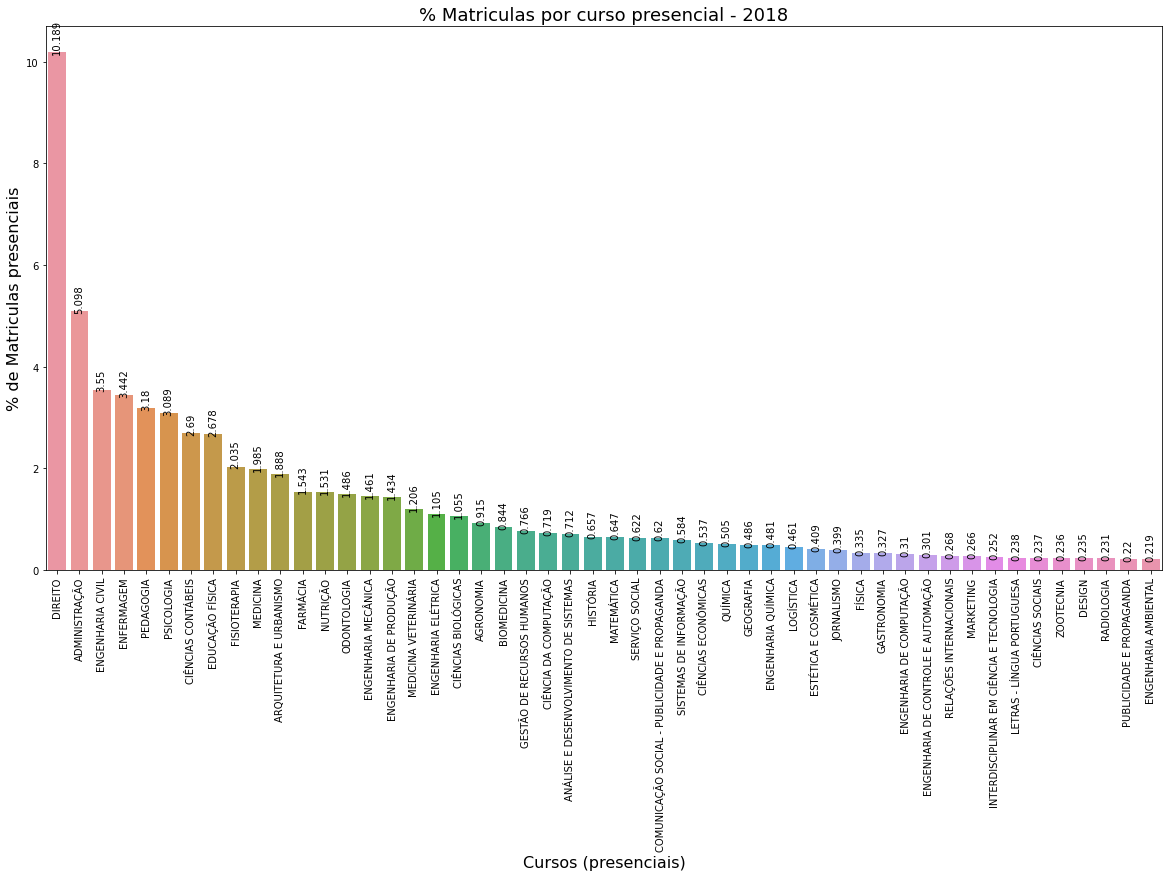

In [334]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= total_matriculas_presenciais.sort_values(ascending=False).head(50).index, 
    y= np.around((total_matriculas_presenciais.sort_values(ascending=False).head(50).values/total_alunos_matriculados)*100,3))

plt.xlabel("Cursos (presenciais)", fontdict={'fontsize':16})
plt.ylabel("% de Matriculas presenciais", fontdict={'fontsize':16})

plt.title('% Matriculas por curso presencial - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Para ter uma visão mais detalhada, abaixo separei apenas as matriculas realizadas em IES privadas. 
# Assim conseguimos ver se há uma diferença entre os cursos que vem sendo mais demandados nas IES privadas, em relação ao quadro geral do país.


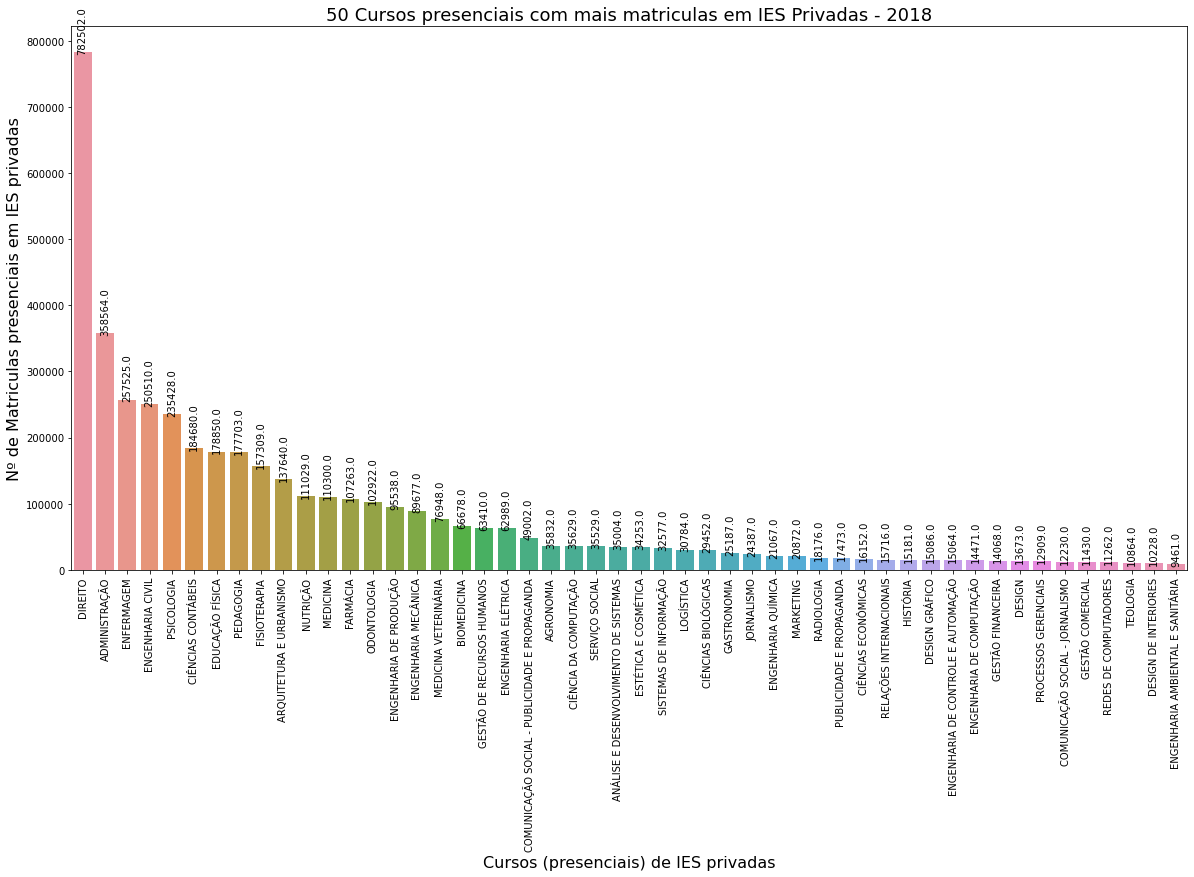

In [301]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).index, y= cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (presenciais) de IES privadas", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas presenciais em IES privadas", fontdict={'fontsize':16})

plt.title('50 Cursos presenciais com mais matriculas em IES Privadas - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)


# Conforme pode ser visto acima, Direito, Administração, Enfermagem e Eng. Civil, continuam sendo os cursos mais procurados, ratificando o que haviamos visto ao analisar o numero total de matriculas não segregadas por rede de ensino. Tivemos apenas uma alteração na ordem entre Enfermagem e Eng. Civil.

# Abaixo a análise percentual (%), mas apenas para a rede privada de ensino.

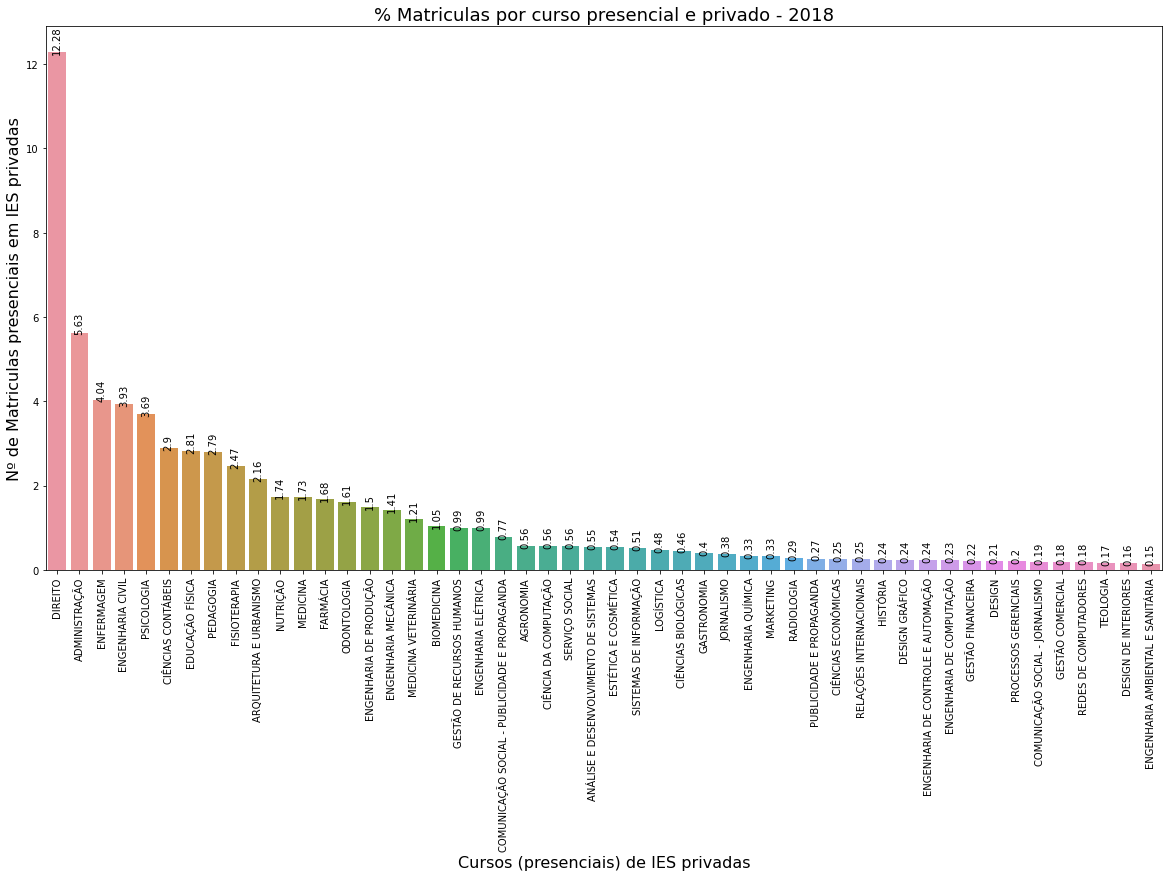

In [115]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).index,
    y= np.around((cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).values/total_matriculas_privadas)*100,2))

plt.xlabel("Cursos (presenciais) de IES privadas", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas presenciais em IES privadas", fontdict={'fontsize':16})

plt.title('% Matriculas por curso presencial e privado - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

In [106]:
total_matriculas_novas_presenciais = cursos_graduacao_presenciais.groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False)

In [108]:
total_matriculas_novas_presenciais.sum()

1780080

# Ao olhar apenas as novas matrículas, pode-se ver que os novos ingressos mostram uma tendência de mudança dos cursos mais procurados.

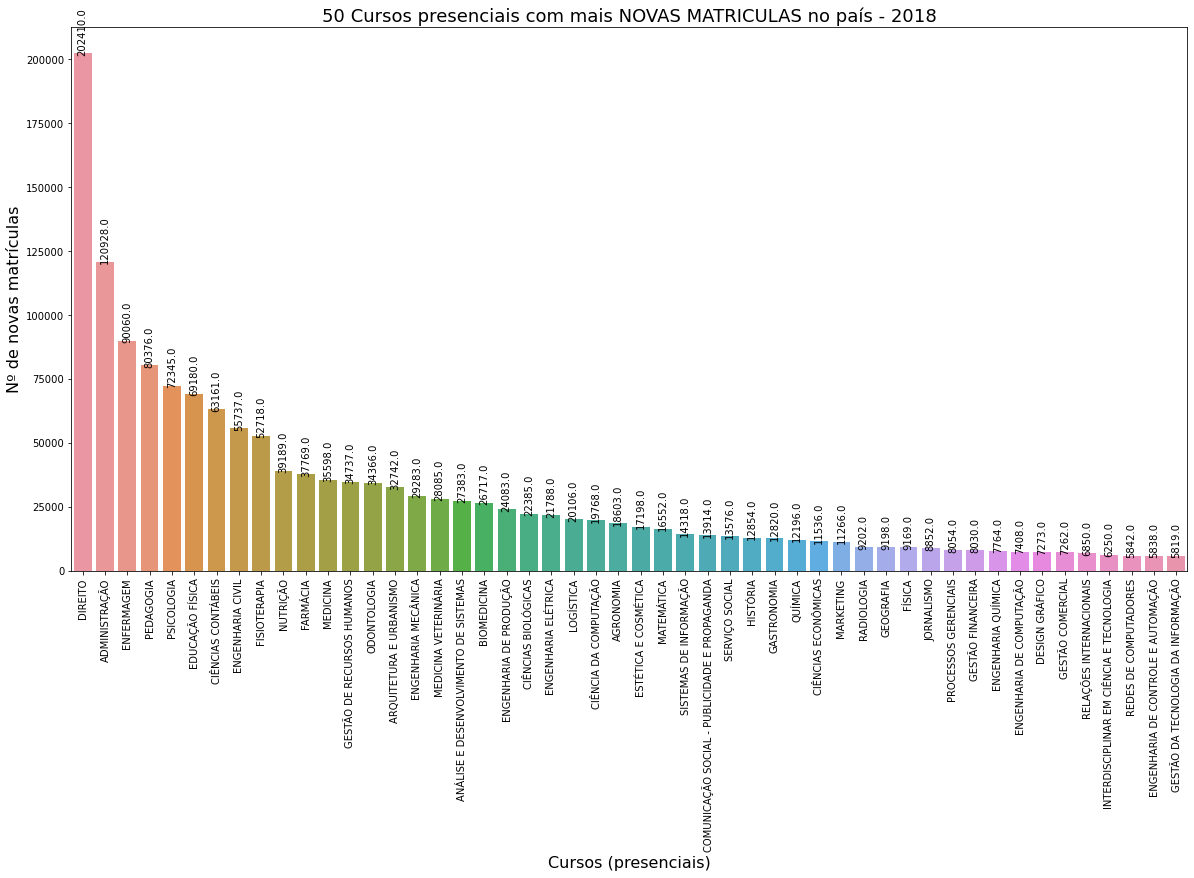

In [289]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= total_matriculas_novas_presenciais.sort_values(ascending=False).head(50).index, y= total_matriculas_novas_presenciais.sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (presenciais)", fontdict={'fontsize':16})
plt.ylabel("Nº de novas matrículas", fontdict={'fontsize':16})

plt.title('50 Cursos presenciais com mais NOVAS MATRICULAS no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Analisando o gráfico abaixo, com o % de novas matriculas nos cursos e, comparando os valores com o gráfico que nos apresenta o % de matriculas totais dos cursos, vemos que os 3 cursos com mais matrículas continuam sendo os 3 que mais tiveram ingresso de novos alunos.

# No entanto há variações em relações a outros cursos. Engenharia Civil, por exemplo, o 4º Curso com o maior número de matriculas ativas é apenas 8ª em novas matriculas. Por outro lado Pedagogia, o 8º Curso com mais matriculas ativas é o 4º em novas matriculas.

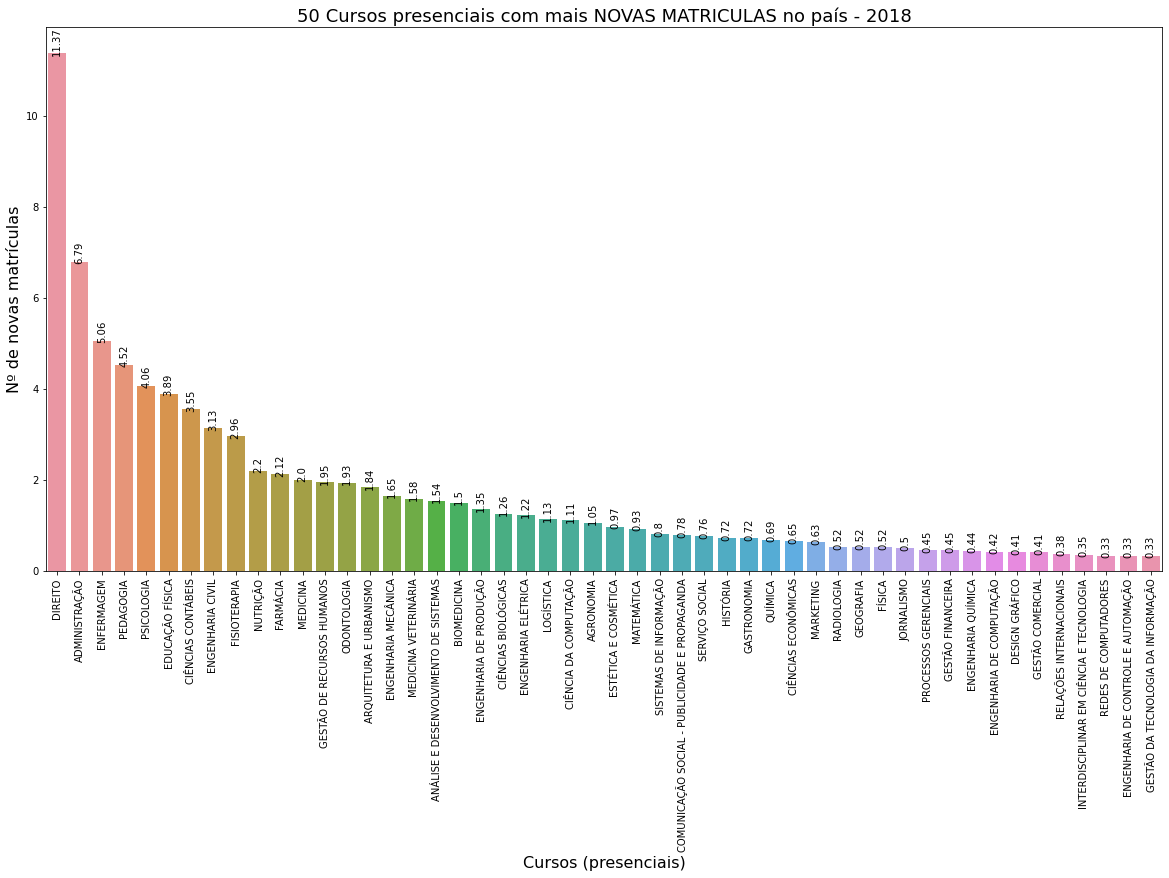

In [114]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= total_matriculas_novas_presenciais.sort_values(ascending=False).head(50).index,
               y= np.around((total_matriculas_novas_presenciais.sort_values(ascending=False).head(50).values/total_matriculas_novas_presenciais.sum())*100,2))

plt.xlabel("Cursos (presenciais)", fontdict={'fontsize':16})
plt.ylabel("Nº de novas matrículas", fontdict={'fontsize':16})

plt.title('50 Cursos presenciais com mais NOVAS MATRICULAS no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Matriculas totais por curso, separadas estado a estado

In [116]:
#Abaixo fiz um agrupamento para analisar os 50 cursos com mais matriculas para cada um dos estados do país.


cursos_graduacao_presenciais.groupby(['SIG_UF', 'NO_CURSO'])['QT_MATRICULA_TOTAL'].sum()

SIG_UF  NO_CURSO                             
AC      ABI - CIÊNCIAS SOCIAIS                    38
        ADMINISTRAÇÃO                            983
        AGROECOLOGIA                             174
        AGROINDÚSTRIA                             69
        ANÁLISE E DESENVOLVIMENTO DE SISTEMAS     88
                                                ... 
TO      SISTEMAS PARA INTERNET                   204
        TEATRO                                   283
        TURISMO                                    0
        TURISMO PATRIMONIAL E SOCIOAMBIENTAL     107
        ZOOTECNIA                                624
Name: QT_MATRICULA_TOTAL, Length: 4674, dtype: int64

# Analise cursos EAD

In [153]:
#Abaixo fiz uma query que modifica diversos valores que anteriormente estavam em códigos pelos textos que cada código representa
#....bem como limitei a consulta à apenas os cursos EAD. Como retorno tenho uma tabela com todos os cursos EAD do país e, dentre
#....outras informações o número de matrículas.

query = """

SELECT
    DISTINCT CO_CURSO,
    CO_IES,
    NO_CURSO,
    QT_MATRICULA_TOTAL,
    NU_ANO_CENSO,
    QT_INGRESSO_TOTAL,
    QT_INGRESSO_VAGA_NOVA,
    QT_INSCRITO_TOTAL,
    QT_CONCLUINTE_TOTAL,
    
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END as PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituição,
CASE
    WHEN TP_MODALIDADE_ENSINO = '1' THEN 'Presencial'
    ELSE 'Curso a distância (EAD)'
END as 'Modalidade_Ensino'
FROM DM_CURSO

WHERE Modalidade_Ensino = 'Curso a distância (EAD)' AND TP_NIVEL_ACADEMICO = '1'

"""
cursos_graduacao_ead = pd.read_sql_query(query, db) 

# Abaixo temos os 50 cursos EAD com maior número de alunos matriculados no país em 2018

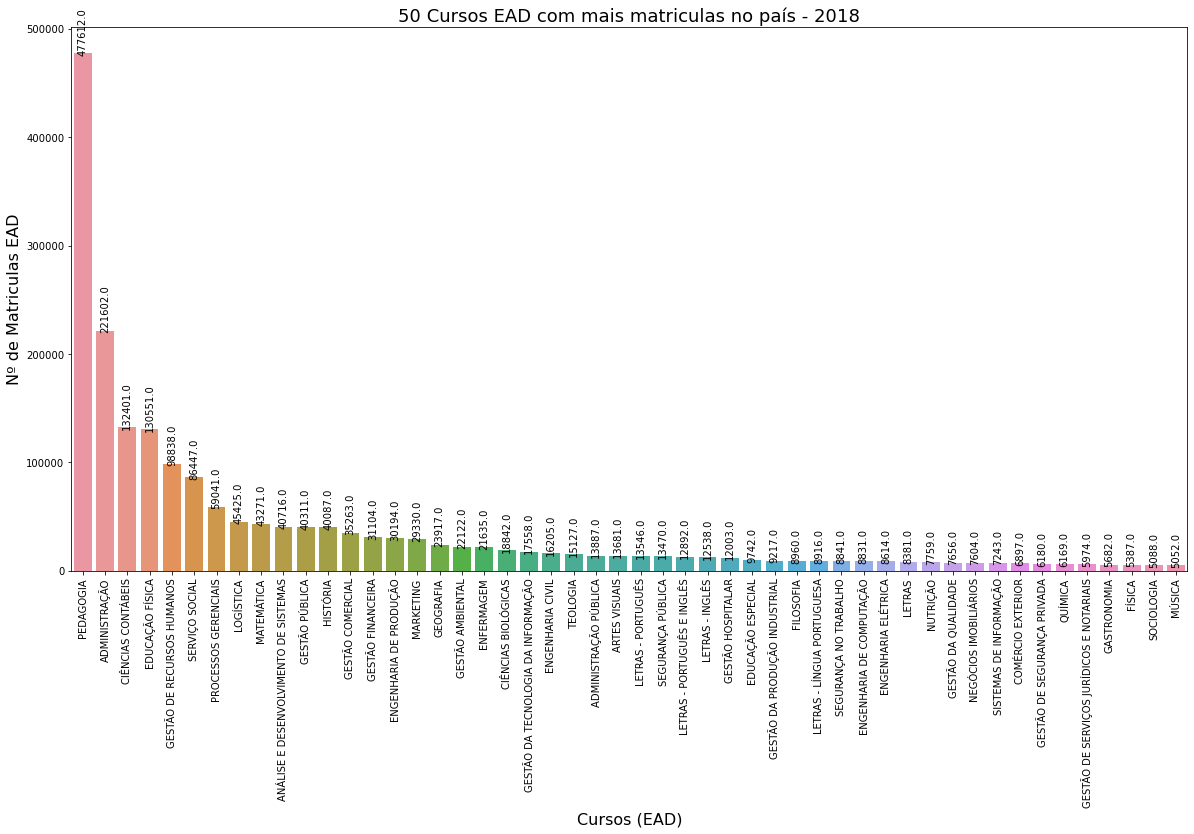

In [151]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_ead.groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).head(50).index, y= cursos_graduacao_ead.groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (EAD)", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas EAD", fontdict={'fontsize':16})

plt.title('50 Cursos EAD com mais matriculas no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Percentual(%) de matriculas EAD em relação a todas as matrículas da rede privada

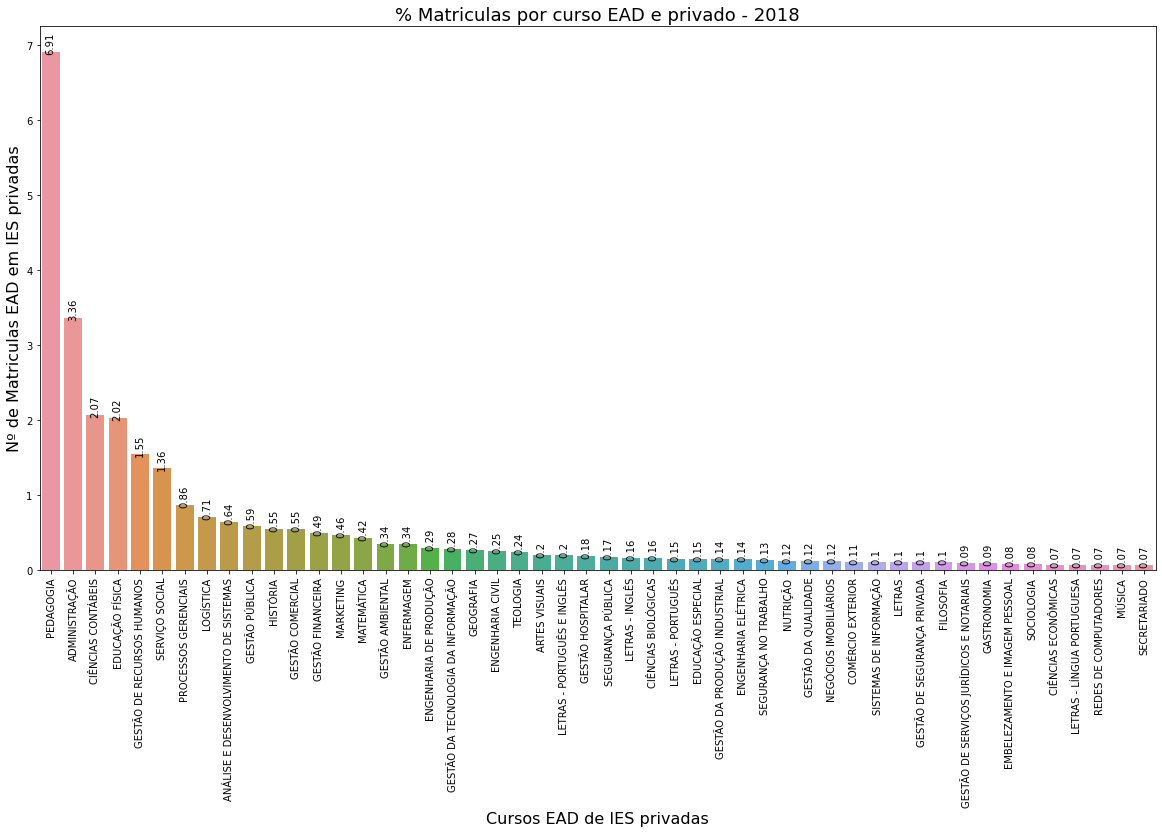

In [152]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_ead[cursos_graduacao_ead['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).index,
    y= np.around((cursos_graduacao_ead[cursos_graduacao_ead['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).values/total_matriculas_privadas)*100,2))

plt.xlabel("Cursos EAD de IES privadas", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas EAD em IES privadas", fontdict={'fontsize':16})

plt.title('% Matriculas por curso EAD e privado - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Analisando as novas matrículas em cursos EAD no país

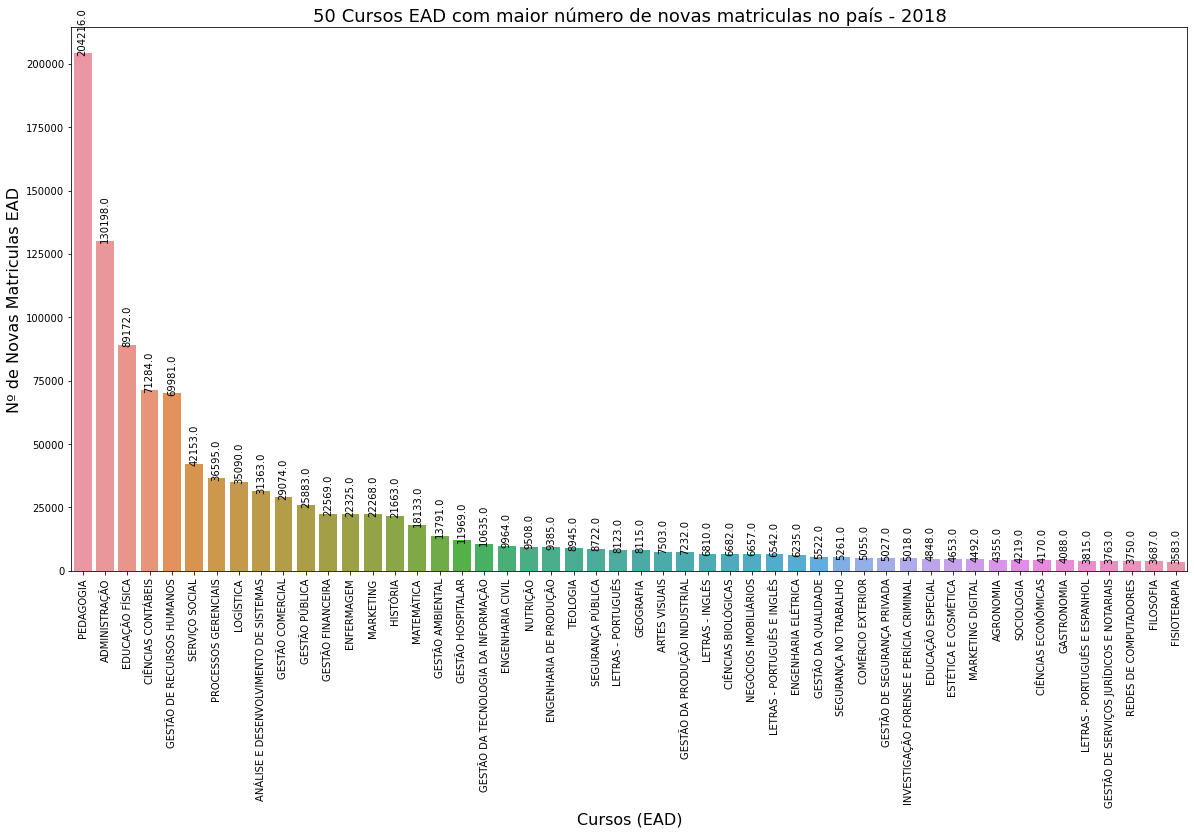

In [154]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_ead[cursos_graduacao_ead['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False).head(50).index,
y= cursos_graduacao_ead[cursos_graduacao_ead['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (EAD)", fontdict={'fontsize':16})
plt.ylabel("Nº de Novas Matriculas EAD", fontdict={'fontsize':16})

plt.title('50 Cursos EAD com maior número de novas matriculas no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Fazendo uma análise percentual apenas das novas matriculas vemos que não há variação ao considerar os novos ingressos em comparação com o volume total de matriculas, curso a curso.

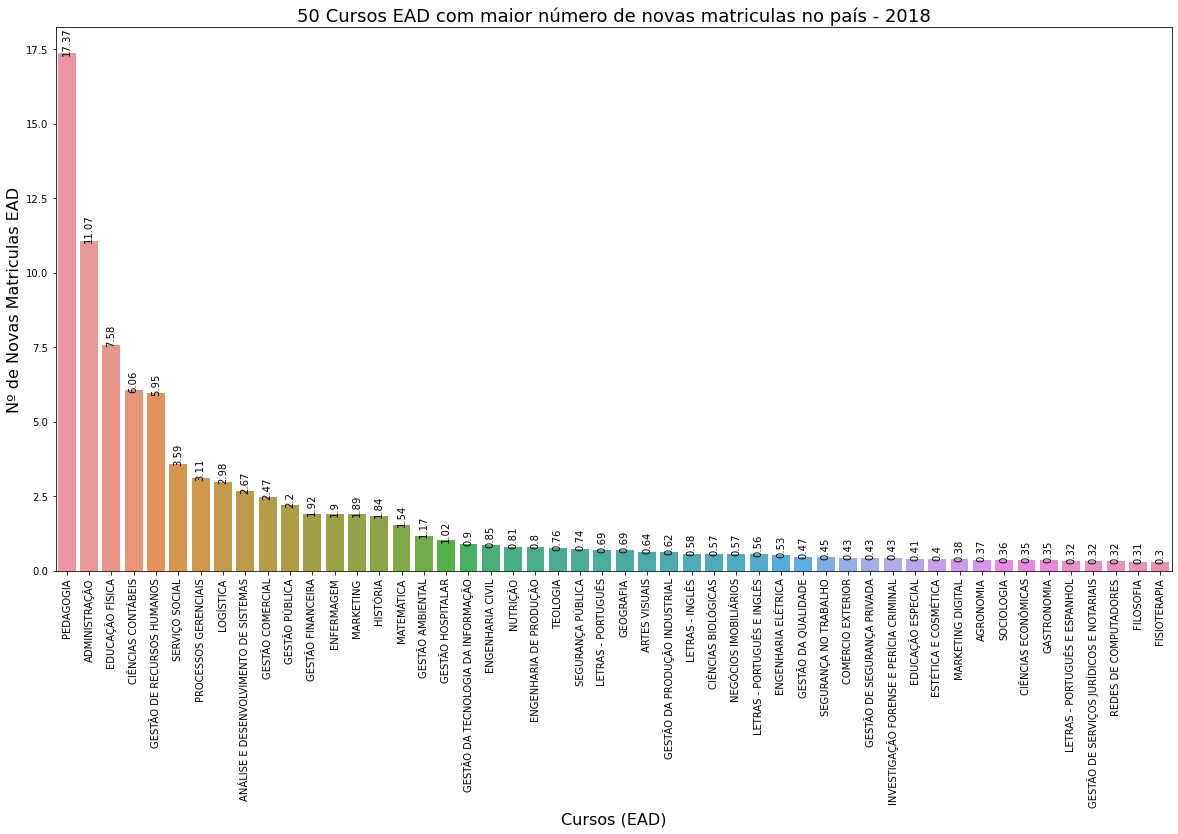

In [501]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_ead[cursos_graduacao_ead['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False).head(50).index,
y= np.around(100*(cursos_graduacao_ead[cursos_graduacao_ead['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False).head(50).values)/(cursos_graduacao_ead[cursos_graduacao_ead['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum()).sum(),2))

plt.xlabel("Cursos (EAD)", fontdict={'fontsize':16})
plt.ylabel("Nº de Novas Matriculas EAD", fontdict={'fontsize':16})

plt.title('50 Cursos EAD com maior número de novas matriculas no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Ao ver essa lista uma curiosidade que tive foi quanto ao curso de Direito, por ser um curso muito popular imaginei que o mesmo estivesse nessa lista acima, no entanto esse não apareceu, ao fazer uma consulta específica vi que não existe nenhum curso EAD de Direito no DataSet.

In [488]:
df_CURSO_graduacao[(df_CURSO_graduacao['NO_CURSO'] == 'DIREITO') & df_CURSO_graduacao['Modalidade de Ensino'] == 'Curso a distância (EAD)']['NO_CURSO'].count()

0

# Com essa informação em mãos fui buscar mais informações e descobri que em 2018 o curso de direito não estava na lista dos cursos EAD autorizados pelo MEC.

# Já sabemos quais os curso mais procurados tanto na modalidade presencial, quando EAD, bem como entendemos a tendência de novas matrículas para cada um deles.

# No entando acho importante analisarmos como se comportam os alunos quanto a desistência. 

# Para isso resolvi iniciar a análise buscando qual o percentual de alunos  que não concluem o curso, por região. Assim poderia descobrir se alunos de alguma região tem uma tendência maior a não concluir os cursos superiores comparados ao restante do país, o que pode significar um risco maior para abertura de novos cursos por IE Privadas naquela região, uma vez que a taxa de ocupação é fundamental para a viabilidade econômica do curso.

In [165]:
#Foram cridos 2 dicionários para auxiliar na resolução da questão

regiao = {1: 'NORTE',
          2: 'NORDESTE',
          3: 'SULDESTE',
          4: 'SUL',
          5: 'CENTRO OESTE'}

TP_SITUACAO = {2: 'Cursando',
               3: 'Matrícula trancada',
               4: 'Desvinculado do curso',
               5: 'Transferido para outro curso da mesma IES',
               6: 'Formado',
               7: 'Falecido'}

In [479]:
#Para a consulta abaixo consideramos apenas os alunos cuja situação era a de número 4, ou seja, que efetivamente se desvincularam
#....do curso

query = """
SELECT
DM_IES.CO_REGIAO,
COUNT(*) AS Qt_alunos_desistentes
FROM
    DM_ALUNO
LEFT JOIN
    DM_IES
    ON DM_ALUNO.CO_IES = DM_IES.CO_IES
WHERE TP_SITUACAO IN (4)
GROUP BY CO_REGIAO

    
"""

df_alunos_desistentes = pd.read_sql(query, db)
df_alunos_desistentes.head()

,CO_REGIAO,Qt_alunos_desistentes
0,1,624984
1,2,1928680
2,3,6525354
3,4,3965848
4,5,1654332


In [480]:
df_alunos_desistentes['NO_REGIAO'] = df_alunos_desistentes.CO_REGIAO.map(regiao)
df_alunos_desistentes

,CO_REGIAO,Qt_alunos_desistentes,NO_REGIAO
0,1,624984,NORTE
1,2,1928680,NORDESTE
2,3,6525354,SULDESTE
3,4,3965848,SUL
4,5,1654332,CENTRO OESTE


In [179]:
query = """

SELECT 
DISTINCT (tb1.ID_ALUNO),
COUNT (tb1.ID_ALUNO),
tb2.CO_REGIAO

FROM
    DM_ALUNO as tb1
LEFT JOIN
    DM_IES as tb2
    ON tb1.CO_IES = tb2.CO_IES
GROUP BY tb2.CO_REGIAO

"""

df_alunos_matriculados = pd.read_sql(query, db)
df_alunos_matriculados.head()

,ID_ALUNO,COUNT (tb1.ID_ALUNO),CO_REGIAO
0,4676EBA5B53251AA8C3775A96533D9AD,3934294,1
1,39DA133C7058D1E03B11367504042071,12902900,2
2,B4153A0D4C49AAE969EE21506F2F4783,37375716,3
3,558E16197F3EEC46DC21BCD51E163362,18611276,4
4,2ECD7C9BEA7DCEBC31B9F2874D454F71,7151786,5


In [185]:
df_alunos_matriculados.drop(['ID_ALUNO'], axis=1, inplace=True)

In [193]:
df_alunos_matriculados.rename(columns={'COUNT (tb1.ID_ALUNO)':'Total Alunos'}, inplace=True)

In [194]:
df_alunos_matriculados

,Total Alunos,CO_REGIAO
0,3934294,1
1,12902900,2
2,37375716,3
3,18611276,4
4,7151786,5


In [481]:
aux = pd.merge(df_alunos_desistentes, df_alunos_matriculados, how='inner',  on='CO_REGIAO')

In [482]:
aux['NO_REGIAO'] = aux.CO_REGIAO.map(regiao)

In [483]:
#Criando uma variável para retornar a taxa de abandono por região

aux['%'] = round((aux['Qt_alunos_desistentes']/aux['Total Alunos'])*100,2)

In [484]:
aux

,CO_REGIAO,Qt_alunos_desistentes,NO_REGIAO,Total Alunos,%
0,1,624984,NORTE,3934294,15.89
1,2,1928680,NORDESTE,12902900,14.95
2,3,6525354,SULDESTE,37375716,17.46
3,4,3965848,SUL,18611276,21.31
4,5,1654332,CENTRO OESTE,7151786,23.13


# Observamos que alunos do Centro-Oeste são aqueles com o maior pencentual de abandono do curso, 23,13%, ligeiramente superior aos da região sul, 21,31%.

# Os alunos da região nordeste são os com menor pencentual de desistência, 14,95%.

# Esses dados, juntamente com a taxa de desistência do cursos em si, são fundamentais para uma análisa da viabilidade econômica de criação de um novo curso em determinada localidade.

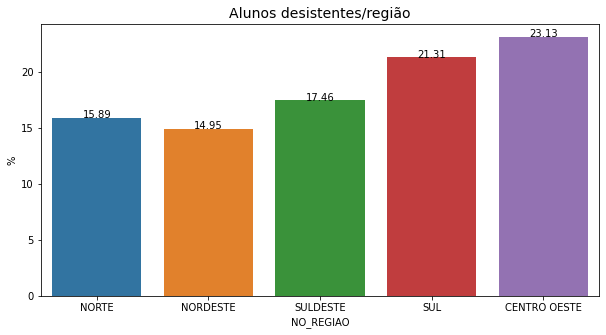

In [485]:
plt.figure(figsize = (10, 5))
s = sn.barplot(data = aux, x = 'NO_REGIAO', y = '%')
plt.title('Alunos desistentes/região', size = 14)
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')
plt.show()

# Quais os cursos que tem maior taxa de desistencia?

In [291]:
# Primeiramente estou buscando uma lista com todos os estudantes de graduação cadastrados na tabela DM_ALUNO


query = """
SELECT
CO_CURSO,
CO_IES,
IN_FIN_REEMB_FIES,
IN_INGRESSO_VAGA_NOVA,
CASE
    WHEN TP_MODALIDADE_ENSINO = '1' THEN 'Presencial'
    WHEN TP_MODALIDADE_ENSINO = '2' THEN 'Curso a distância (EAD)'
END as 'Modalidade de Ensino'

FROM
    DM_ALUNO 
    
WHERE TP_NIVEL_ACADEMICO = '1' AND TP_GRAU_ACADEMICO IN (1,2,4)
"""

historico_cadastro_alunos_graduacao_ = pd.read_sql(query, db)

In [296]:
#abaixo selecionei apenas a colunas CO_CURSO e fiz a contagem de quantas vezes esses valores de repetiam, com isso tive como 
#....resultado uma Serie onde o index era o codigo de cada curso e o valor ao lado o número de alunos que já estiveram cadastrados
#....nesse curso

cadastros_curso = historico_cadastro_alunos_graduacao_['CO_CURSO'].value_counts()

In [335]:
#Abaixo estou transformando a Serie em um DataFrame

cadastros_curso_aux = pd.DataFrame(cadastros_curso.sort_index())

In [336]:
#Abaixo estou renomeando a colouna que eu havia feito o agrupamento, ou seja, a que me da o numero total de alunos

cadastros_curso_aux.rename(columns={'CO_CURSO':'Total Alunos'}, inplace=True)

In [338]:
#Abaixo estou trazendo o index, que são os Codigos dos Cursos, para se tornar novamente uma coluna do DataFrame. Esses CO_CURSO
#....haviam sido usados como objeto do agrupamento anteriormente, ou seja, as desistências haviam sido agrupadas por código, o que
#....fez com que esses códigos se tornassem o index da Serie.

cadastros_curso_aux['CO_CURSO'] = teste.index

In [340]:
#Abaixo estou resetando o index e usando o parâmetro 'drop=' para informar que eu não quero que os valores do index sejam
#....guardados e apareçam ao lado das colunas.

cadastros_curso_aux.reset_index(drop=True)

,Total Alunos,CO_CURSO
0,2052,1
1,2332,2
2,1284,3
3,1844,6
4,1628,7
...,...,...
38206,80,5001434
38207,189,5001437
38208,192,5001451
38209,162,5001464


In [254]:
#Criando uma tabela com os nomes e codigos de todos os cursos para poder fazer um merge na célula abaixo

query = """
SELECT 
DISTINCT CO_CURSO,
NO_CURSO

FROM
    DM_CURSO
WHERE TP_GRAU_ACADEMICO IN (1,2,4)
"""

cursos = pd.read_sql(query, db)

In [357]:
#Abaixo fiz um merge, ou seja, uni 2 DataFrames, fiz isso pois queria uma coluna com o o Nome dos Cursos que estava no DF cursos

cadastros_curso_aux = pd.merge(cadastros_curso_aux, cursos, on='CO_CURSO')

In [449]:
#Abaixo estou criando um DataFrame com todos os alunos desistentes por Curso

query = """

SELECT 
tb1.CO_CURSO,
COUNT (DISTINCT tb1.ID_ALUNO) as Desistentes_curso,

FROM
    DM_ALUNO as tb1
    
LEFT JOIN
    DM_CURSO as tb2
    ON tb1.CO_IES = tb2.CO_IES
    
WHERE tb1.TP_SITUACAO = '4' AND TP_GRAU_ACADEMICO IN (1,2,4)

GROUP BY tb1.CO_CURSO

"""
desistentes_curso = pd.read_sql(query, db)

DatabaseError: Execution failed on sql '

SELECT 
tb1.CO_CURSO,
COUNT (DISTINCT tb1.ID_ALUNO) as Desistentes_curso,
tb2.TP_SITUACAO

FROM
    DM_ALUNO as tb1
    
LEFT JOIN
    DM_CURSO as tb2
    ON tb1.CO_IES = tb2.CO_IES
    
WHERE tb1.TP_SITUACAO = '4'

GROUP BY tb1.CO_CURSO

': database or disk is full

In [421]:
#Abaixo estou criando um novo DataFrame resultado da união do DataFrame que tem todos os cadastros de aluno por Cursos, com outro
#.... que possui o total de desistências registradas para esse mesmo curso.

desistentes_cursos_aux = pd.merge(cadastros_curso_aux, desistentes_curso, on='CO_CURSO')

In [422]:
desistentes_cursos_aux

,Total Alunos,CO_CURSO,NO_CURSO,Desistentes_curso
0,2052,1,DIREITO,9
1,2332,2,CIÊNCIAS ECONÔMICAS,87
2,1284,3,ENGENHARIA CIVIL,12
3,1844,6,PEDAGOGIA,24
4,1628,7,SERVIÇO SOCIAL,67
...,...,...,...,...
35345,80,5001434,GESTÃO DA TECNOLOGIA DA INFORMAÇÃO,8
35346,189,5001437,AUTOMAÇÃO INDUSTRIAL,1
35347,192,5001451,"INTERDISCIPLINAR EM CIÊNCIA, TECNOLOGIA E INOV...",2
35348,162,5001464,ABI - LETRAS,2


In [423]:
#Abaixo estou criando uma nova feature no DataFrame com a taxa de abadono (desistencia) para cada curso.

desistentes_cursos_aux['Tx_desistencia'] = round((desistentes_cursos_aux['Desistentes_curso']/desistentes_cursos_aux['Total Alunos'])*100,2)

In [434]:
#Aqui estou apenas realocando a ordem das colunas para fins de organização

desistentes_cursos_aux = desistentes_cursos_aux.reindex(columns=['NO_CURSO', 'CO_CURSO', 'Total Alunos', 'Desistentes_curso', 'Tx_desistencia'])

In [502]:
#Estou definindo quantas linhas quero que sejam apresentadas no output
pd.set_option('display.max_rows', 500)


#Abaixo posso analisar uma lista com os cursos de menor taxa de desistência, caso a visualização seja mais fácil do que no gráfico
desistentes_cursos_aux[desistentes_cursos_aux['Total Alunos']>5000].sort_values(by='Tx_desistencia').head(100000).groupby(by='NO_CURSO')['Tx_desistencia'].mean().sort_values().head(50)

NO_CURSO
FORMAÇÃO DE DOCENTES PARA A EDUCAÇÃO BÁSICA           0.810000
CIÊNCIAS JURÍDICAS E SOCIAIS                          0.970000
MEDICINA                                              1.061667
RÁDIO, TV E INTERNET                                  1.840000
INTERDISCIPLINAR EM CIÊNCIAS E HUMANIDADES - BI/LI    1.860000
CIÊNCIA DA COMPUTAÇÃO                                 1.910000
ABI - LETRAS                                          1.980000
EDUCAÇÃO ESPECIAL                                     2.170000
RADIOLOGIA                                            2.370000
ODONTOLOGIA                                           2.483333
DESIGN DE INTERIORES                                  3.405000
PSICOLOGIA                                            3.530588
INTERDISCIPLINAR EM CIÊNCIA E TECNOLOGIA              3.570000
LETRAS                                                3.693333
ARQUITETURA E URBANISMO                               3.847143
MEDICINA VETERINÁRIA                          

In [498]:
#Visualizando o resultado da realocação e da feature TX_desistencia.
#Nessa celula estamos selecionando apenas cursos com mais de 2000 alunos no cadastro historico, e dentre esses escolhemos as 1000
#....100000 menores taxas de desistência.
#....Por fim estamos agrupandos os cursos de mesmo nome que se enquadraram nos parâmetros da busca. Dessa forma que estabelecemos
#....a consulta estamos conseguindo evitar que algum curso com alta taxa de desistência influencie cursos de mesmo nome que não
#....o tem, evitando assim a influência de outliers.


desistentes_cursos_grafico = np.around(desistentes_cursos_aux[desistentes_cursos_aux['Total Alunos']>5000].sort_values(by='Tx_desistencia').head(100000).groupby(by='NO_CURSO')['Tx_desistencia'].mean(),2).sort_values().head(50)

# Para encontrar os cursos com menor taxa de desistência é importante considerar diversas situações, existem tipos de cursos ofertados em poucos lugares, cursos mais tradicionais são ofertados em muitos lugares o que pode levar a uma chance maior de termos uma instituição de péssimo padrão na qual a desistência seja alta afetando a média.

# Optei por cria uma fórmula na qual defino os cursos e o tamanho da amostra, para posteriormente as informações serem agrupadas por cursos de mesmo noma e a taxa de desistência é a média dentre os iguais.

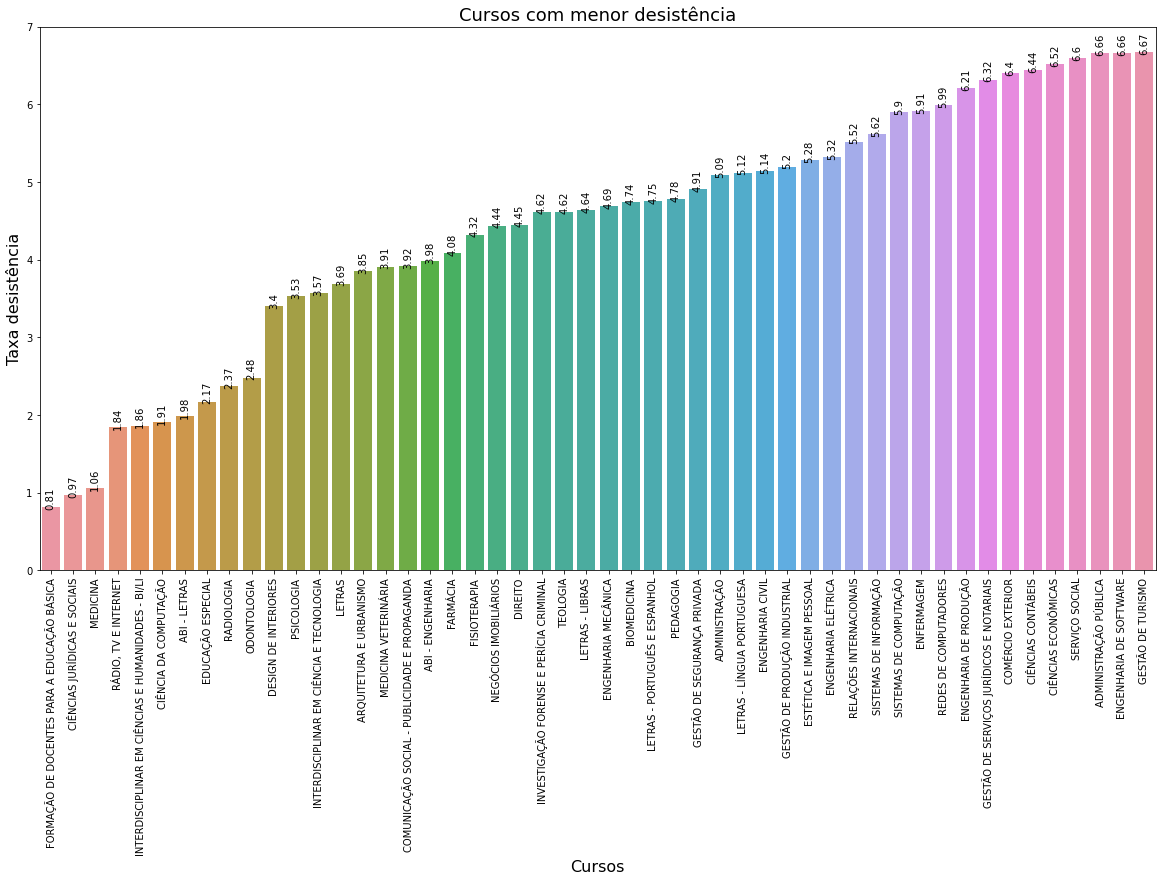

In [499]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= desistentes_cursos_grafico.index,
               y= desistentes_cursos_grafico.values)

plt.xlabel("Cursos", fontdict={'fontsize':16})
plt.ylabel("Taxa desistência", fontdict={'fontsize':16})

plt.title('Cursos com menor desistência', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Analisando o gráfico acima, no qual consideramos apenas cursos com mais de 5000 alunos já cadastrados, podemos analisar que temos vários cursos tradicionais na lista.

# Medicina tem uma taxa de desistência de apenas 1,06%, extremamente baixa, uma possibilidade é que essa taxa esteja relacionada com a alta empregabilidade desta profissão.

# Outros cursos tradicionais que se destacaram por baixa taxa de desistência foram:
- Ciência da Computação (1,91%)
- Odontologia (2,48%)
- Psicologia (3,55%)
- Arquitetura e urbanismo (3,84%)
- Medicina Veterinária (3,90%)
- Farmácia (4,8%)
- Direito (4,44%)
- Pedagogia (4,77%)
- Administração (5,08%)
- Engenharia Civil (5,14%)

# Por fim busquei encontrar a tendência dos cursos que vem sendo mais procurandos atualmente. Para isso além de já ter analisado os dados do Censo 2018, busquei os dados do Cendo 2019 e 2020.

In [694]:
colunasSelecionadas = ['NU_ANO_CENSO', 'CO_IES', 'CO_UF', 'SG_UF', 'NO_CINE_ROTULO', 'CO_CINE_ROTULO',
                      'TP_MODALIDADE_ENSINO', 'TP_NIVEL_ACADEMICO', 'QT_VG_TOTAL', 'QT_VG_NOVA', 'QT_INSCRITO_TOTAL',
                      'QT_INSC_VG_NOVA', 'QT_SIT_TRANCADA', 'QT_SIT_DESVINCULADO']

In [695]:
dados_2019 = pd.read_csv('D:/caiof/MATERIAL DE ESTUDO OUTROS/DATA SCIENCE/CURSO - DATA SCIENCE - DIGITAL HOUSE/Modulo 1/Aula27_20220427_Desafio_1/microdados_censo_da_educacao_superior_2019/Microdados do Censo da Educaç¦o Superior 2019/dados/MICRODADOS_CADASTRO_CURSOS_2019.csv',sep=';', encoding='latin1', usecols=colunasSelecionadas)
dados_2019.head()

,NU_ANO_CENSO,SG_UF,CO_UF,CO_IES,NO_CINE_ROTULO,CO_CINE_ROTULO,TP_MODALIDADE_ENSINO,TP_NIVEL_ACADEMICO,QT_VG_TOTAL,QT_VG_NOVA,QT_INSCRITO_TOTAL,QT_INSC_VG_NOVA,QT_SIT_TRANCADA,QT_SIT_DESVINCULADO
0,2019,MT,51.0,1,Pedagogia,0113P01,2,1,0,0,0,0,8,3
1,2019,MT,51.0,1,Computação formação de professor,0114C05,2,1,0,0,0,0,2,11
2,2019,MT,51.0,1,Administração pública,0413A02,2,1,0,0,0,0,6,2
3,2019,MT,51.0,1,Matemática formação de professor,0114M01,2,1,0,0,0,0,13,0
4,2019,MT,51.0,1,Ciências naturais formação de professor,0114C02,2,1,0,0,0,0,2,7


In [696]:
#Abaixo estou filtrando apenas os curso de graduação o somatório de vagas e inscritos, por Ano e por Nome do curso.

vagas_cursos_2019 = dados_2019[dados_2019['TP_NIVEL_ACADEMICO'] == 1].groupby(['NU_ANO_CENSO','NO_CINE_ROTULO'])[['QT_INSCRITO_TOTAL', 'QT_VG_TOTAL']].sum()

In [697]:
#Abaixo estou criando a coluna com o percentual de concorrência por vaga

vagas_cursos_2019['CONCORRENCIA/VAGA'] = np.around((vagas_cursos_2019['QT_INSCRITO_TOTAL']/vagas_cursos_2019['QT_VG_TOTAL']),2)

In [698]:
#Abaixo estou demostrando como acessas individualmente multiindex do meu agrupamento, usarei essa função na protagem do grafico

vagas_cursos_2019.loc[2019].index

Index(['ABI Artes e humanidades',
       'ABI Ciências naturais, matemática e estatística',
       'ABI Ciências sociais, comunicação e informação',
       'ABI Computação e Tecnologias da Informação e Comunicação (TIC)',
       'ABI Educação', 'ABI Engenharia, produção e construção',
       'ABI Saúde e bem-estar', 'Administração', 'Administração pública',
       'Agrimensura',
       ...
       'Teatro formação de professor', 'Telemática', 'Teologia',
       'Terapia ocupacional', 'Toxicologia', 'Transporte aéreo',
       'Transporte terrestre', 'Turismo', 'Viticultura e enologia',
       'Zootecnia'],
      dtype='object', name='NO_CINE_ROTULO', length=342)

# Para tomar uma decisão comercial acerca da viabilidade de um novo curso outros dois fatores que eu consideraria seriam o volumente e a tendência de inscritos em um curso, bem como a taxa de concorrência por vaga, pois um aumento nessa taxa demonstra claramente um aumento da demanda, que se não estiver sendo totalmente absorvida me dá uma oportunidade de negócio de ampliar a oferta para esses cursos.

# Essa visão podemos ter nos quadros abaixo que apesentam de forma bem visivel nos anos de 2019 os cursos mais procurados em números absolutos, bem como aqueles que as vagas existentes não suprem ainda a demanda.

In [699]:
vagas_cursos_2019.sort_values(by='QT_INSCRITO_TOTAL', ascending=False)

QT_INSCRITO_TOTAL  \
NU_ANO_CENSO NO_CINE_ROTULO                                                          
2019         Administração                                                 2058826   
             Pedagogia                                                     1471633   
             Direito                                                       1194452   
             Medicina                                                      1075264   
             Enfermagem                                                    1056477   
             Contabilidade                                                  627066   
             Psicologia                                                     570058   
             Fisioterapia                                                   531636   
             Gestão de pessoas                                              504963   
             Educação física                                                473754   
             Nutrição                                                       467422   
             Sistemas de informação                                         448478   
             Engenharia civil                                               436531   
             Educação física formação de professor                          377170   
             Serviço social                                                 325259   
             Biomedicina                                                    299228   
             Logística                                                      292107   
             Farmácia                                                       291907   
             Odontologia                                                    263848   
             Medicina veterinária                                           261457   
             Arquitetura e urbanismo                                        245713   
             Agronomia                                                      229726   
             Engenharia de produção                                         227608   
             Marketing                                                      214250   
             Engenharia mecânica                                            210353   
             Matemática formação de professor                               206652   
             História formação de professor                                 192465   
             Gestão de negócios                                             187106   
             Biologia formação de professor                                 185055   
             Letras português formação de professor                         179243   
             Engenharia elétrica                                            164929   
             Gestão pública                                                 158628   
             Estética e cosmética                                           157986   
             Ciência da computação                                          149578   
             Gestão comercial                                               147612   
             Gestão financeira                                              144608   
             Economia                                                       132890   
             Gestão hospitalar                                              128404   
             Letras português inglês formação de professor                  119651   
             Publicidade e propaganda                                       119111   
             Geografia formação de professor                                107710   
             Gastronomia                                                    102000   
             Jornalismo                                                      95359   
             Gestão ambiental                                                90754   
             Turismo                                                         82940   
             Química fo

In [700]:
vagas_cursos_2019.sort_values(by='CONCORRENCIA/VAGA', ascending=False)

QT_INSCRITO_TOTAL  \
NU_ANO_CENSO NO_CINE_ROTULO                                                          
2019         Medicina                                                      1075264   
             ABI Computação e Tecnologias da Informação e Co...               2145   
             Engenharia aeroespacial                                          4513   
             Ciências militares                                               9903   
             Letras português língua brasileira de sinais                      896   
             Estradas                                                         2104   
             Saúde pública                                                     476   
             Produção editorial                                               1470   
             Astronomia                                                       1294   
             Sistemas de telecomunicações                                     3964   
             Produção têxtil                                                  2169   
             Telemática                                                       2993   
             Irrigação e drenagem                                             1653   
             Bioquímica                                                       2017   
             Educação infantil formação de professor                           908   
             Ciências ambientais                                              4873   
             Engenharia naval                                                 2088   
             Ciências agrárias formação de professor                          4389   
             História da arte                                                 1909   
             Arquivologia                                                     9622   
             Mineração                                                        1194   
             ABI Ciências sociais, comunicação e informação                  26625   
             ABI Artes e humanidades                                         47450   
             ABI Saúde e bem-estar                                            8369   
             Programas interdisciplinares abrangendo saúde e...               6980   
             Engenharia nuclear                                                328   
             ABI Engenharia, produção e construção                           18970   
             Toxicologia                                                       318   
             Letras português italiano formação de professor                   541   
             ABI Ciências naturais, matemática e estatística                 38267   
             Ecologia                                                         3149   
             Letras outras línguas estrangeiras modernas                      1029   
             Engenharia de pesca                                             11444   
             Conservação e restauro                                           1466   
             Saúde coletiva                                                   7773   
             Programas interdisciplinares abrangendo artes e...              17542   
             Biotecnologia                                                    9666   
             Agroecologia                                                    11887   
             Letras português outras línguas estrangeiras mo...               1586   
             Saneamento ambiental                                            10608   
             ABI Educação                                                     8906   
             Engenharia de transportes                                        2860   
             Ciências sociais                                                19537   
             Educação indígena formação de professor                          2151   
             Artes cênicas                                                    4595   
             Cinema e a

# Administração foi o curso mais inscritos em 2019, seguido de Pedagogia, ambos tiveram um crescimento em relação a Direito. Mas regra geral, os cursos mais tradicionais continuam sendo os mais procurados.

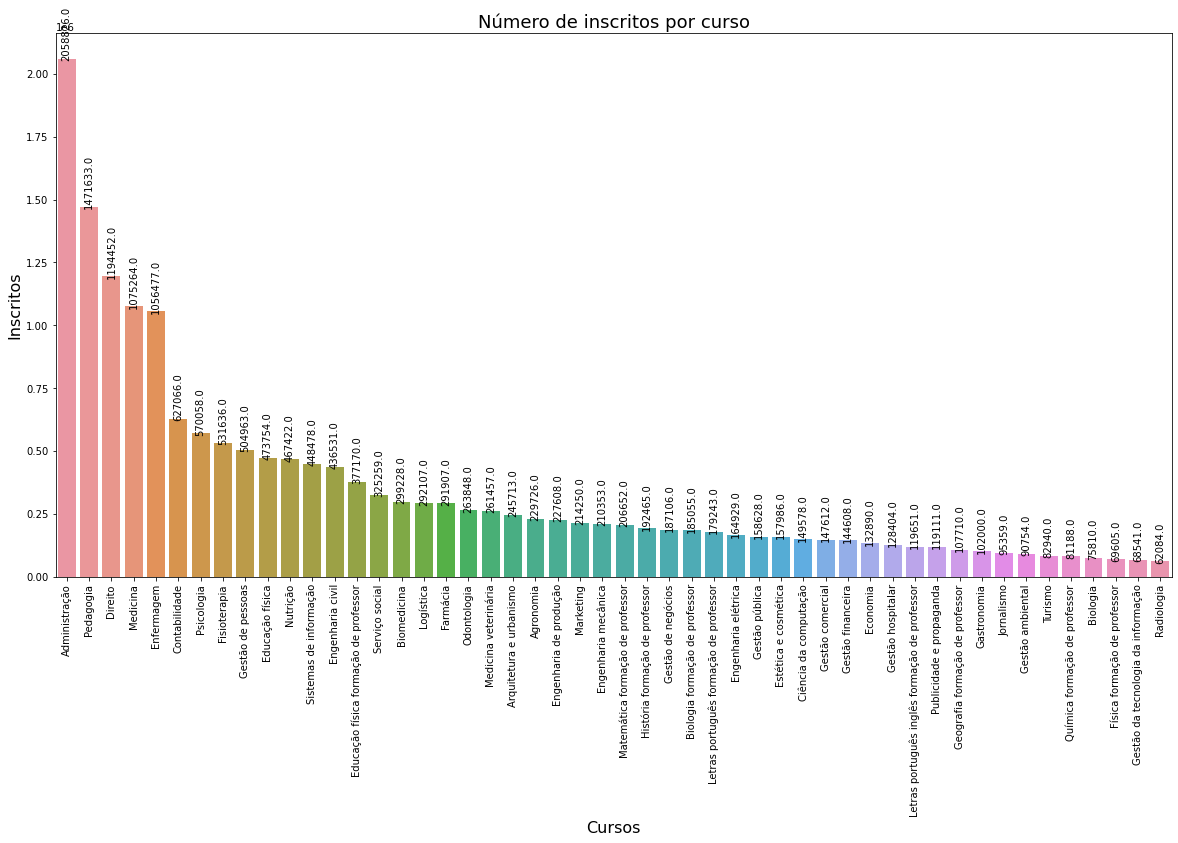

In [701]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= vagas_cursos_2019.sort_values(by='QT_INSCRITO_TOTAL', ascending=False).head(50).loc[2019].index,
               y= vagas_cursos_2019.sort_values(by='QT_INSCRITO_TOTAL', ascending=False).head(50).QT_INSCRITO_TOTAL)

plt.xlabel("Cursos", fontdict={'fontsize':16})
plt.ylabel("Inscritos", fontdict={'fontsize':16})

plt.title('Número de inscritos por curso', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Abaixo temos os 50 cursos com maior concorrência por vaga

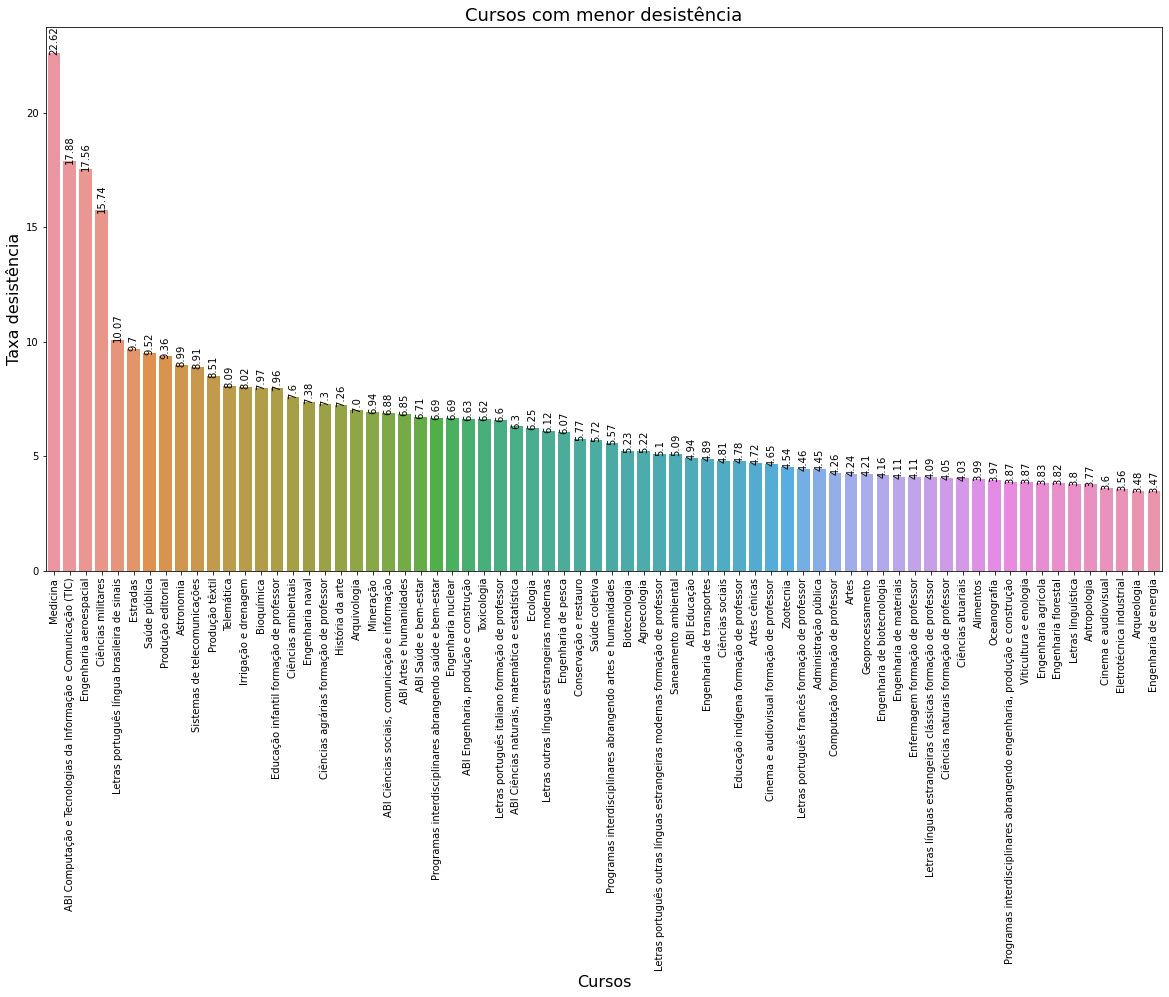

In [707]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= vagas_cursos_2019.sort_values(by='CONCORRENCIA/VAGA', ascending=False).head(70).loc[2019].index,
               y= vagas_cursos_2019.sort_values(by='CONCORRENCIA/VAGA', ascending=False).head(70)['CONCORRENCIA/VAGA'])

plt.xlabel("Cursos", fontdict={'fontsize':16})
plt.ylabel("Taxa desistência", fontdict={'fontsize':16})

plt.title('Cursos com menor desistência', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

In [619]:
dados_2020 = pd.read_csv('D:/caiof/MATERIAL DE ESTUDO OUTROS/DATA SCIENCE/CURSO - DATA SCIENCE - DIGITAL HOUSE/Modulo 1/Aula27_20220427_Desafio_1/microdados_censo_da_educacao_superior_2020/Microdados do Censo da Educaç¦o Superior 2020/dados/MICRODADOS_CADASTRO_CURSOS_2020.csv',sep=';', encoding='latin1', usecols=colunasSelecionadas)
dados_2020.head()

,NU_ANO_CENSO,SG_UF,CO_UF,CO_IES,NO_CINE_ROTULO,CO_CINE_ROTULO,TP_MODALIDADE_ENSINO,TP_NIVEL_ACADEMICO,QT_VG_TOTAL,QT_VG_NOVA,QT_INSCRITO_TOTAL,QT_INSC_VG_NOVA,QT_SIT_TRANCADA,QT_SIT_DESVINCULADO
0,2020,MT,51.0,1,Pedagogia,0113P01,2,1,0,0,0,0,1,10
1,2020,MT,51.0,1,Computação formação de professor,0114C05,2,1,0,0,0,0,0,6
2,2020,MT,51.0,1,Administração pública,0413A02,2,1,0,0,0,0,1,10
3,2020,MT,51.0,1,Matemática formação de professor,0114M01,2,1,0,0,0,0,5,11
4,2020,MT,51.0,1,Pedagogia,0113P01,2,1,0,0,0,0,0,0


In [620]:
vagas_cursos_2020 = dados_2020[dados_2020['TP_NIVEL_ACADEMICO'] == 1].groupby(['NU_ANO_CENSO','NO_CINE_ROTULO'])[['QT_INSCRITO_TOTAL', 'QT_VG_TOTAL']].sum()
vagas_cursos_2020['CONCORRENCIA/VAGA'] = np.around((vagas_cursos_2020['QT_INSCRITO_TOTAL']/vagas_cursos_2020['QT_VG_TOTAL']),2)

In [711]:
vagas_cursos_2020.sort_values(by='QT_INSCRITO_TOTAL', ascending=False)

QT_INSCRITO_TOTAL  \
NU_ANO_CENSO NO_CINE_ROTULO                                                          
2020         Administração                                                 1878253   
             Pedagogia                                                     1334211   
             Direito                                                       1202366   
             Medicina                                                      1067303   
             Enfermagem                                                     953935   
             Psicologia                                                     650938   
             Contabilidade                                                  643408   
             Sistemas de informação                                         588806   
             Educação física                                                581512   
             Gestão de pessoas                                              504114   
             Educação física formação de professor                          461461   
             Fisioterapia                                                   402910   
             Nutrição                                                       399828   
             Engenharia civil                                               382131   
             Biomedicina                                                    332350   
             Serviço social                                                 323751   
             Farmácia                                                       297179   
             Logística                                                      287234   
             Medicina veterinária                                           278782   
             Odontologia                                                    273137   
             Marketing                                                      270404   
             Arquitetura e urbanismo                                        249370   
             História formação de professor                                 226869   
             Matemática formação de professor                               209304   
             Engenharia mecânica                                            202670   
             Biologia formação de professor                                 193800   
             Engenharia de produção                                         190217   
             Letras português formação de professor                         188864   
             Gestão de negócios                                             174617   
             Engenharia elétrica                                            174361   
             Gestão financeira                                              172981   
             Gestão pública                                                 168697   
             Agronomia                                                      166385   
             Estética e cosmética                                           163479   
             Gestão hospitalar                                              162158   
             Gestão comercial                                               158318   
             Economia                                                       156365   
             Ciência da computação                                          151642   
             Publicidade e propaganda                                       114348   
             Geografia formação de professor                                110823   
             Jornalismo                                                     104427   
             Gestão ambiental                                               100315   
             Gastronomia                                                     99944   
             Serviços jurídicos e cartoriais                                 93434   
             Letras português inglês formação de professor                   82999   
             Artes visu

In [710]:
vagas_cursos_2020.sort_values(by='CONCORRENCIA/VAGA', ascending=False)

QT_INSCRITO_TOTAL  \
NU_ANO_CENSO NO_CINE_ROTULO                                                          
2020         Ciências militares                                              58752   
             ABI Computação e Tecnologias da Informação e Co...               2726   
             Medicina                                                      1067303   
             Letras português japonês                                          134   
             Engenharia aeroespacial                                          4075   
             Enfermagem formação de professor                                 5398   
             Astronomia                                                       1640   
             Educação infantil formação de professor                           635   
             Produção editorial                                               1341   
             Produção têxtil                                                  2586   
             Criação digital                                                  4538   
             Letras português italiano                                         172   
             Artes cênicas                                                    7793   
             Letras português outras línguas estrangeiras mo...                140   
             ABI Ciências sociais, comunicação e informação                  30380   
             Irrigação e drenagem                                              883   
             Engenharia nuclear                                                404   
             Toxicologia                                                       346   
             Ciências ambientais                                              4601   
             Estradas                                                         1493   
             Letras português italiano formação de professor                   631   
             Letras outras línguas estrangeiras modernas                      1394   
             ABI Ciências naturais, matemática e estatística                 41026   
             Bioquímica                                                       1583   
             Cinema e audiovisual formação de professor                        451   
             História da arte                                                 1677   
             Engenharia naval                                                 1497   
             Letras português língua brasileira de sinais                      664   
             ABI Artes e humanidades                                         37066   
             Letras português outras línguas estrangeiras mo...               1879   
             Arquivologia                                                     9770   
             Conservação e restauro                                           1069   
             Ecologia                                                         2554   
             Letras português inglês                                          1081   
             Saúde coletiva                                                   7040   
             Letras linguística                                                532   
             Sistemas de telecomunicações                                     2155   
             Ciências sociais                                                19698   
             Biotecnologia                                                    8709   
             ABI Educação                                                     7575   
             ABI Engenharia, produção e construção                           16226   
             Letras línguas estrangeiras clássicas                              78   
             Engenharia cartográfica                                           926   
             Psicologia formação de professor                                 3159   
             Educação indígena formação de professor                          2012   
             Programas 

# A mesma análise foi feita para 2020, assim, como 3 anos podemos ter maior confiança ao afirmar que há ou não uma tendência de crescimento na procura por um determinado curso.

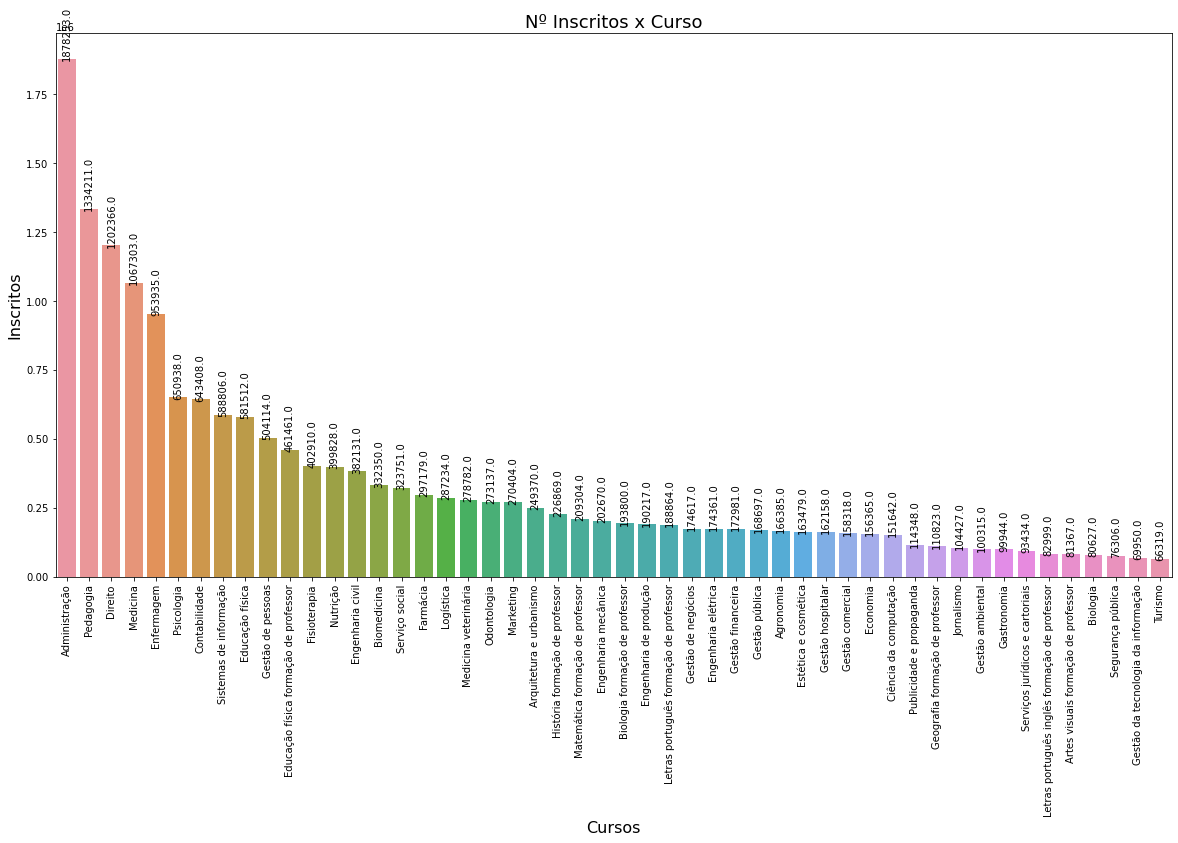

In [622]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= vagas_cursos_2020.sort_values(by='QT_INSCRITO_TOTAL', ascending=False).head(50).loc[2020].index,
               y= vagas_cursos_2020.sort_values(by='QT_INSCRITO_TOTAL', ascending=False).head(50).QT_INSCRITO_TOTAL)

plt.xlabel("Cursos", fontdict={'fontsize':16})
plt.ylabel("Inscritos", fontdict={'fontsize':16})

plt.title('Nº Inscritos x Curso', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

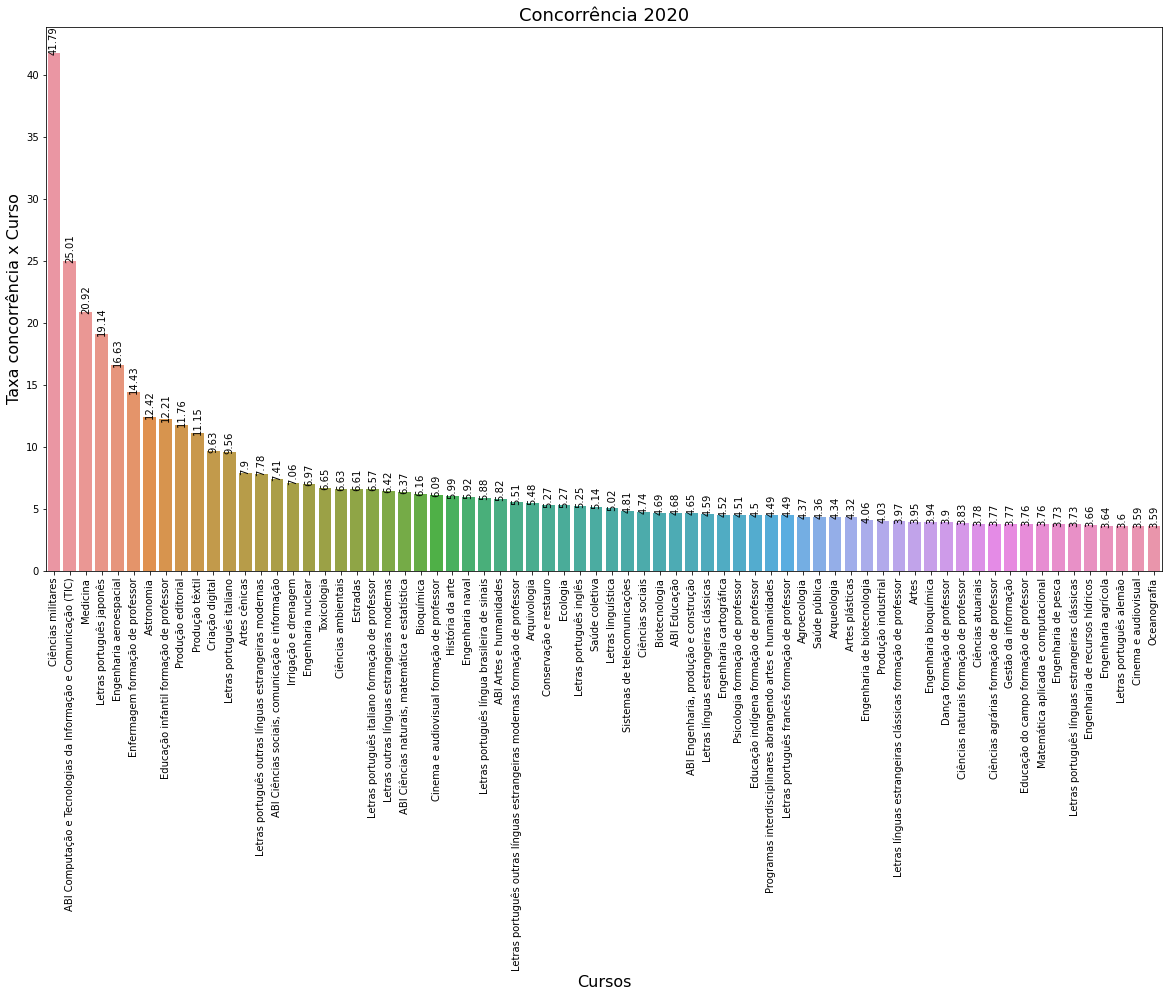

In [706]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= vagas_cursos_2020.sort_values(by='CONCORRENCIA/VAGA', ascending=False).head(70).loc[2020].index,
               y= vagas_cursos_2020.sort_values(by='CONCORRENCIA/VAGA', ascending=False).head(70)['CONCORRENCIA/VAGA'])

plt.xlabel("Cursos", fontdict={'fontsize':16})
plt.ylabel("Taxa concorrência x Curso", fontdict={'fontsize':16})

plt.title('Concorrência 2020', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Se você tivesse que abrir um curso (apenas um curso de graduação), qual seria, onde ele seria, qual a modalidade?



- **Novos ingressos e Concorrência por vaga:**

O primeiro ponto que eu analisaria ao pensar em abrir um novo curso seria a demanda, para isso utilizaria as análise de novas matrícula e de concorrência por vaga para escolher cursos que o número de ingressos vem crescendo, mas que a taxa de concorrência ainda seja maior do que 1, pois isso significa que o mercado ainda não está saturado, quanto maior a taxa de concorrência melhor, desde que o volume de novas matriculas seja grande, pois isso representaria há um grande nicho nicho. Só a concorrência isoladamente também não é uma boa métricas, elas precisam ser enxergadas em conjunto

- **Taxa de Desistência:**

O segundo ponto a ser analisado é o risco do curso, para isso eu vou analisar a Taxa de Desistência que isolamos nessa análise. Cursos com alta taxa de desistência podem representar um risco pois eu preciso de um percentual mínimo da turma ocupada para evitar prejuízo, bem como quanto maior a taxa de ocupação da turma maior o meu lucro.

- **Modalidade de ensino e/ou local:**

O terceiro ponto para analisar seria em qual local abrir o curso precisamos analisar os novos ingressos e a taxa de desistência por região. Assim eu vou ver os cursos que tem grande volume de novos ingressos, mas alta taxa de concorrência naquela região, mas também preciso analisar a taxa de desistência pra aquela região. Pela análise que fiz todas as regiões do país tem uma taxa de desistência geral inferior a 25%, logo todas se apresenta com potencial viável, em especial o nordeste com uma baixissima taxa geral de desistência.

No entanto há que se considerar que há comprovadamente uma enorme tendência de aumento na demanda por **cursos EAD**, os quais além de tudo acabam com minha necessida de ter que escolher uma região ou cidade específica focada na demanda local. Com eles eu posso atender a demanda de todo o país.

- **Custo de implantação:**
O quarto ponto a ser analisado é o curso de implantação. Alguns cursos, em especial da saúde tem alta curso de implantação, logo eu focaria, dentro dos cursos que obedeceram os 3 critérios anteriores, em cursos com menor custo de implantação.

- **Conclusão:**
Diante de todos os pontos acima elencados e dos dados fiz a seguinte análise:

Como minha intenção é abrir um curso de graduação e eu quero o reconhecimento do MEC, a lista de cursos na modalidade EAD já ficam reduzidos pois tenho que me ater a lista de reconhecimentos pelo MEC.
- Administração
- Administração Pública
- Agronomia
- Arquitetura e Urbanismo
- Biblioteconomia
- Ciências Contábeis
- Comunicação Social - Publicidade e Propaganda
- Enfermagem
- Engenharia Agronômica
- Engenharia Ambiental
- Engenharia Civil
- Engenharia de Alimentos
- Engenharia de Computação
- Engenharia de cControle e Automação
- Engenharia de Petróleo
- Engenharia de Produção
- Engenharia Elétrica
- Engenharia Mecânica
- Fisioterapia
- Fonoaudiologia
- Jornalismo
- Nutrição
- Relações Públicas
- Serviço Social
- Sistemas de Informação
- Teologia


Te todos os cursos da modalidade EAD, ao analisar um a um considerando os pontos de análise que elenquei acima cheguei em 3 opções. Administração é um curso de alto com maior volume de novas inscrições do pais e com concorrência média de 1.72, ainda não completamente saturada. Sua taxa de desistência média é de 5%. Agronomia é um curso com baixa taxa de desistência, boa concorrência, 1,9 e um número de inscrições razoável, 166385. 

No entanto o curso que escolheria para abrir seria o curso de **Enfermagem**, curso possível de implantação na modalidade EAD, reconhecido pelo MEC, com número número de incrições ainda alto em 2020, 953935, embora com uma leve tendência de diminuição entre 2018 e 2020. Sua taxa de concorrência média é de 2.58 o que mostra que ainda não é um mercado saturado e a sua taxa de desistência é das mais baixas. Por fim o fato de ter poucas instituições credenciadas pelos MEC para a implantação na modalidade EAD, bem como a grande visibilidade quanto a importância da profissão que vimos nesses últimos 2 anos e a aprovação do piso da profissão me faz crer que a tendência será de maior procura por esse curso nos próximos anos.


# Selecione um curso à sua escolha. Para este curso, considerando a taxa de abandono calculada no exerício 5, considere uma classe de 100 alunos. Além disso, considere que, para o curso se pagar, a turma deve terminar com, pelo menos, 60 alunos. Para cada aluno abaixo dos 60 alunos que desistir, o prejuízo será de 1000 reais. Assim sendo, calcule:

    - A probabilidade de a turma gerar prejuízo
    - O risco financeiro deste curso

In [705]:
close_access_database(db,csqlite)

Acesso ao banco de dados fechado com sucesso
